***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document 6</span> 

# Modern Helmholtz Machine - Modifications and Implementations

This notebook presents an analysis on the structures of the Helmholtz Machine, along with experiments of certain modifications to the vanilla model. The goal (not yet achieved and not sure if it's possible) is to build a generative model that not only generates data from the dataset but recovers the data distribution.

The modifications include:
- Adding bias in linear combinations
- Changing assignment values
- Inserting MLP to compute better correlation between adjacent layers, enabling backpropagation of multiple layers as DNN
- Modifying updating rules
- Conditional distribution that takes care of explain-away and independent sampling (not sure if it's necessary.. which would add much computational load)

*Updated:* December 21, 2023

Result: It does! The (vanilla) Helmholtz machine approximates a full variational Bayes approach and reconstructs the data distribution within its ability. The result shows that it tries to approximate the evidence (given data distribution) with decreasing distribution difference (over the entire dataset). In the mean time, due to the limitation of the machine, it cannot reconstruct the distribution perfectly. The model presents a distribution difference $ \approx 0.076$  and accuracy $ \approx 0.94$) after training, which is not bad honestly. Therefore, the model is generating a few false instances in order to minimize the global distribution difference between the evidence and generation. Then we can perform **active sampling**, which is the core idea of the work and thought I am proposing all the time, to achieve a perfect accuracy with skewed distribution (the niche). Then all the theory of free energy principle, niche co-construction, etc. follows naturally. The ability of performing active sampling during training is the core reason for me choose the Helmholtz machine. This trait empowers the neural network to train and perform more human-likely, which paves the way to study cognition, humanity, culture, creativity and musicology quantitively by neural networks. It contributes to music research and explaining musical phenomena naturally because music is a human thing, it's created by human, defined by human, evaluated by human and updated by human. It's subjective, which cannot simply be learned by data fitting and generalized by interpolation. All these thoughts are embryonic and needs to be illustrated, realized and tested by huge amount of work. 

<img src="result.png" style="width:800px">
<caption><center> Vanilla Training Result    </center></caption>

<img src="{1,-1} Training Result.png" style="width:800px">
<caption><center> {1,-1} Training Result    </center></caption>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The modified Helmholtz machine structure is given below:

<img src="Modern.jpg" style="width:800px">
<caption><center> **Figure 1**: Modern Helmholtz Machine. Blue neurons represent instantiation layers, where the neurons take binary values. Orange neurons indicate the inserted activations, where the neurons take value in real numbers in given range.    </center></caption>

Notation on data:
- Dataset $D$: random variable, the goal is to (implicitly) maximize evidence $P(D)$
- Phenotype layer $d_0$: single data input, observable state
- $d$: single data point, observable variable

Notation on hidden layers:
- $z_i$: $i$-th instantiated hidden layer, random variable.
- $s_i$: value assignment of $i$-th instantiated hidden layer, hidden state
- $q(z_i[k])$: probability of $k$-th neuron in $z_i$ in recognition process
- $p(z_i[k])$: probability of $k$-th neuron in $z_i$ in generative process
- $q(z_i)$: probability of $z_i$ in recognition process, since the sampling of neurons are independent, $q(z_i) = \prod_k q(z_i[k])$
- $p(z_i)$: probability of $z_i$ in generative process, since the sampling of neurons are independent, $p(z_i) = \prod_k p(z_i[k])$
- $l^{i,i+1}_j$: $j$-th inserted hidden layers between $z_i$ and $z_{i+1}$, multilayer perceptron

Parameters (amortized):
- $\Phi$: recognition weights, compute neuron values bottom-up in wake phase.
- $\Theta$: generative weights, compute neuron values top-down in sleep phase.

#### Define model structure

n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
n is the maximum number of inserted layers between adjacent instantiation layers.

A neural network in Figure 1 has structure ndarray:
$$
n_{dz} = 
\begin{pmatrix}
10 & 8 & 6 & 3 & 1 \\
9 & 0 & 5 & 0 & 0 \\
0 & 0 & 4 & 0 & 0  \\
\end{pmatrix}
$$

The first row gives the number of neurons in each instantiation layer. The second row represents the first inserted layer, and there is a 9-neuron layer inserted between $d_0$ and $z_1$, a 5-neuron layer inserted between $z_2$ and $z_3$. The third row represents the second inserted layer, and there is only one 4-neuron layer inserted between $z_2$ and $z_3$ above the first 5-neuron inserted layer. Obviously, $n_{dz}(i,k) \ne 0$ if and only if $n_{dz}(i,j) \ne 0, \forall j < k$; the last column of  $n_{dz}$ is all zero except for the value in the first row.

In [2]:
structure = [[10,8,6,3,1],
             [9, 0,5,0,0],
             [0, 0,4,0,0]]
n_dz = np.array(structure)
n_dz

array([[10,  8,  6,  3,  1],
       [ 9,  0,  5,  0,  0],
       [ 0,  0,  4,  0,  0]])

#### Parameter initialization

When deciding parameter sets, the question is on whether to add bias and where to add it. In vanilla Helmholtz machine, the activations are calculated without bias term:

$$p_n^m(\theta, s^{m+1}) = \sigma(\sum_k \theta_{k,n}^{m+1,m} \centerdot s_k^{m+1})$$
$$q_n^m(\phi, s^{m-1}) = \sigma(\sum_k \phi_{k,n}^{m-1,m} \centerdot s_k^{m-1})$$

We'd love to add the option of neuron bias to see how the model behaves, thus the computation becomes

$$p_n^m(\theta, s^{m+1}) = \sigma(\sum_k \theta_{k,n}^{m+1,m} \centerdot s_k^{m+1}+ b_{n}^{m+1,m})$$
$$q_n^m(\phi, s^{m-1}) = \sigma(\sum_k \phi_{k,n}^{m-1,m} \centerdot s_k^{m-1}+ b_{n}^{m-1,m})$$

This minor modification seems trivial, but it may influence the precision of certain neuron predictions significantly. To observe its effects, we further divide the bias trial into 3 situations:

1. Bias on data (bottom) layer
2. Bias on hidden instantiation layers
3. Bias on hidden inserted layers

The experiment will be performed as thus but for now for parameter defining, we initialize the parameter matrix with weights and bias, and choose to use or leave out the bias term afterwards.

There are two types of initialization, random or zero. By neutralizaing all weights and bias to zero, we erase the prior of distributions of hidden variables. By setting the parameters to random numbers, we impose a random prior on hidden $z$'s, which may or may not (needs to be validated) influence the generative distribution on fixed dataset fitting, but it will play a significant role when we perform more subjective tasks such as active sampling and predictive processing.

In [3]:
def parameter_initialization(init_type,n_dz):
    """
    Arguments:
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    
    Returns:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    """
    Phi = {}
    Theta = {}
    m = n_dz.shape[1]
    
    if init_type == "zero":
        for i in range(m-1):
            n = np.where(n_dz[1:,i] != 0)[0].size  # number of inserted layers between i and i+1
            if n == 0:
                Phi["Phi_" + str(i) + str(i+1)] = np.zeros((n_dz[0,i+1],n_dz[0,i]+1))
                Theta["Theta_" + str(i+1) + str(i)] = np.zeros((n_dz[0,i],n_dz[0,i+1]+1))
            else:
                for j in range(1,n+1):
                    Phi["Phi_" + str(i) + str(i+1) + "_" + str(j)] = np.zeros((n_dz[j,i],n_dz[j-1,i]+1))
                    Theta["Theta_" + str(i+1) + str(i) + "_" + str(j)] = np.zeros((n_dz[j-1,i],n_dz[j,i]+1))
                Phi["Phi_" + str(i) + str(i+1) + "_" + str(j+1)] = np.zeros((n_dz[0,i+1],n_dz[j,i]+1))
                Theta["Theta_" + str(i+1) + str(i) + "_" + str(j+1)] = np.zeros((n_dz[j,i],n_dz[0,i+1]+1))
    elif init_type == "random":
        for i in range(m-1):
            n = np.where(n_dz[1:,i] != 0)[0].size
            if n == 0:
                Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(n_dz[0,i+1],n_dz[0,i]+1)
                Theta["Theta_" + str(i+1) + str(i)] = np.random.randn(n_dz[0,i],n_dz[0,i+1]+1)
            else:
                for j in range(1,n+1):
                    Phi["Phi_" + str(i) + str(i+1) + "_" + str(j)] = np.random.randn(n_dz[j,i],n_dz[j-1,i]+1)
                    Theta["Theta_" + str(i+1) + str(i) + "_" + str(j)] = np.random.randn(n_dz[j-1,i],n_dz[j,i]+1)
                Phi["Phi_" + str(i) + str(i+1) + "_" + str(j+1)] = np.random.randn(n_dz[0,i+1],n_dz[j,i]+1)
                Theta["Theta_" + str(i+1) + str(i) + "_" + str(j+1)] = np.random.randn(n_dz[j,i],n_dz[0,i+1]+1)
    
    else:
        raise Exception("Wrong Init Type")
        
    return Phi, Theta

In [4]:
Phi, Theta = parameter_initialization("random",n_dz)

#### Variational Free Energy

The minimization goal of the Helmholtz machine is the variational free energy, also negative ELBO of the log evidence $\log(P(D))$:

$$
F_{\phi,\theta}(D) = \mathbb{E}_Q[\log Q_\phi(\alpha|D)] - \mathbb{E}_Q[\log P_\theta(\alpha,D)] 
$$

where $D$ is the given dataset and $\alpha$ are the latent variable $z_i$'s. Instead of updating parameters on the whole dataset, we perform a stochastic optimization where single data point gets inputted and $\Theta$ and $\Phi$ are updated accordingly. The point-wise objective is

$$
F_{\phi,\theta}(d) = \mathbb{E}_Q[\log Q_\phi(\alpha|d)] - \mathbb{E}_Q[\log P_\theta(\alpha,d)] 
$$

$\Theta$ and $\Phi$ are amortized to all data points and latent assignments, but basically different data points correspond to different latent distributions. It's under question that if the stochastic optimization really approxiamates the integral optimization, but let's proceed here first and see if we can find the answer somewhere somhow...

The parameter updating is performed in an expectation-maximization manner, except that we have two sets of parameters $\Theta$ and $\Phi$. Namely, we use $\Phi$ to calculate the latent assignment $\alpha$ (or in a better way, the distribution of latent variables $z$) and use the computed terms to update $\Theta$; conversely, we can compute the latent terms by $\Theta$ and update $\Phi$ accordingly. Since the latent variables are shared in the feedback neural network, this alternative parameter updating is feasible, which is known as *the wake-sleep algorithm*.

Now let's derive the parameter updation rules. Let's say we fix parameter $\Phi$ and want to update $\Theta$. The first term $\mathbb{E}_Q[\log Q_\phi(\alpha|d)]$ is constant with fixed $\Phi$, thus the minimization goal becomes

$$
L = - \mathbb{E}_Q[\log P_\theta(\alpha,d)] = -\sum_\alpha Q_\phi(\alpha|d)\log P_\theta(\alpha,d)
$$

The term that involves parameter $\Theta$ is $P_\theta(\alpha,d)$, now we try to decompose this term.

In Helmholtz machine, each neuron takes binary value, with probability $p$. Thus every neuron variale $z_n^m$ encodes a Bernoulli distribution, where the probability mass function

$$
p(z_n^m) = 
\left \{
\begin{array}{ll}
p & \text{if } s_n^m = a \\
1-p & \text{if } s_n^m = b
\end{array} \right.
$$

when the neurons take value in $\{a,b\}$. $a$ is the positive outcome with probability $p$, while $b$ is the negative outcome with probability $1-p$. Then the distribution can be written as

$$p(z_n^m) = p^{\frac{s_n^m-b}{a-b}}(1-p)^{\frac{a-s_n^m}{a-b}}$$

Since all neurons are independent random variables,

$$
\begin{align}
P_\theta(\alpha,d) &= \prod_{n,m} [p_n^m(\theta, s^{m+1})]^{\frac{s_n^m-b}{a-b}}[1-p_n^m(\theta, s^{m+1})]^{\frac{a-s_n^m}{a-b}} \\
\log P_\theta(\alpha,d) &= \sum_{n,m} \frac{s_n^m-b}{a-b} \log [p_n^m] + \frac{a-s_n^m}{a-b} \log [1-p_n^m] \\
\frac{\partial \log P_\theta(\alpha,d)}{\partial p_n^m} &= \frac{s_n^m-b}{a-b} \centerdot \frac{1}{p_n^m} - \frac{a-s_n^m}{a-b} \centerdot \frac{1}{1-p_n^m}
\end{align}
$$

From $p_n^m(\theta, s^{m+1}) = \sigma(\sum_k \theta_{k,n}^{m+1,m} \centerdot s_k^{m+1})$ (the bias is integrated into the weights by setting its multiplicative value $s$ to $1$ always) and $\sigma'(x) = \sigma(x)(1-\sigma(x))$ we derive,

$$\frac{\partial p_n^m}{\partial \theta_{k,n}^{m+1,m}} = p_n^m(1-p_n^m)s_k^{m+1}$$

Multiplying the two terms we get

$$
\begin{align}
\frac{\partial \log P_\theta(\alpha,d)}{\partial \theta_{k,n}^{m+1,m}} &= \frac{\partial \log P_\theta(\alpha,d)}{\partial p_n^m} \bullet \frac{\partial p_n^m}{\partial \theta_{k,n}^{m+1,m}} \\
&= s_k^{m+1}(\frac{s_n^m-b}{a-b} - p_n^m) \\
&=  \left \{
\begin{array}{ll}
s_k^{m+1}(1-p_n^m) & \text{if } s_n^m = a \\
-s_k^{m+1} \centerdot p_n^m & \text{if } s_n^m = b
\end{array} \right.
\end{align}
$$

Since $L = -\sum_\alpha Q_\phi(\alpha|d)\log P_\theta(\alpha,d)$,

$$
\frac{\partial L}{\partial \theta_{k,n}^{m+1,m}} = -\sum_\alpha Q_\phi(\alpha|d)\frac{\partial \log P_\theta(\alpha,d)}{\partial \theta_{k,n}^{m+1,m}} = \left \{
\begin{array}{ll}
-\sum_\alpha Q_\phi(\alpha|d)s_k^{m+1}(1-p_n^m) & \text{if } s_n^m = a \\
\sum_\alpha Q_\phi(\alpha|d)s_k^{m+1} \centerdot p_n^m & \text{if } s_n^m = b
\end{array} \right.
$$

By gradient descent,

$$\theta_{k,n}^{m+1,m} = \theta_{k,n}^{m+1,m} - lr \centerdot \frac{\partial L}{\partial \theta_{k,n}^{m+1,m}}$$


From the formula above, we have an important observation: when updating parameter $\Theta$, more specifically $\theta_{k,n}^{m+1,m}$, let alone the expectation over $Q$, it multiplicatively depends on the *possibility* of current neuron $z_n^m$ and the *value assignments* of its connected previous-layer neuron $s_k^{m+1}$. Therefore, one conclusion is that, the binary outcomes of these Bernoulli neuron matter. The larger the outcome value is, the further parameter $\theta_{k,n}^{m+1,m}$ is updated. In the case of $s_k^{m+1} = 0$, no updation is performed for $\theta_{k,n}^{m+1,m}$.

In vanilla Helmholtz machine, binary outcomes $\{0,1\}$ are taken, which actually halfly paralyzed the model because the parameters are not updated when the previous neuron takes value $0$. In our experiment, we changed the values to $\{-1,1\}$, which achieved much better results. What's more, we can experiment with bipolar values such as $\{10,1\}$, $\{100,1\}$, and see how the model behaves.

In [5]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

In [6]:
def wake_sample(n_dz,d0,value_set,Phi,activation_type,bias):
    """
    Arguments:
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    d0 -- input pattern, numpy array of shape (n_d, 1)
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation bias, MLP bias], taking binary value in {True, False}. For example, [False,True] means 
    no instantiation bias but has MLP bias
    
    Returns:
    Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m-1 with each key-value pair being 
    a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
    """
    
    m = n_dz.shape[1]
    S = d0  # assignment of each layer
    Alpha_Q = {"z0":d0}
    inst_bias = bias[0]
    mlp_bias = bias[1]
    a = value_set[0]
    b = value_set[1]
    
    for i in range(m-2):
        n = np.where(n_dz[1:,i] != 0)[0].size  # number of inserted layers between i and i+1
        if n == 0:
            phi = Phi["Phi_" + str(i) + str(i+1)]
            if inst_bias == True:
                q = sigmoid(np.matmul(phi,np.append(S,[[1]], axis=0)))
            else:
                q = sigmoid(np.matmul(phi[:,:-1],S))
            S = ((q > np.random.rand(len(q),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
            Alpha_Q["z"+str(i+1)] = S
        else:
            g = S
            for j in range(1,n+1):
                phi = Phi["Phi_" + str(i) + str(i+1) + "_" + str(j)]
                if activation_type == "sigmoid":
                    if mlp_bias == True:
                        g = sigmoid(np.matmul(phi,np.append(g,[[1]], axis=0)))*(a-b)+b  # scale to [b,a]
                    else:
                        g = sigmoid(np.matmul(phi[:,:-1],g))*(a-b)+b
                elif activation_type == "tanh":
                    if mlp_bias == True:
                        g = np.tanh(np.matmul(phi,np.append(g,[[1]], axis=0)))*(a-b)/2+(a+b)/2 # scale to [b,a]
                    else:
                        g = np.tanh(np.matmul(phi[:,:-1],g))*(a-b)/2+(a+b)/2
                    
            phi = Phi["Phi_" + str(i) + str(i+1) + "_" + str(j+1)]
            if inst_bias == True:
                q = sigmoid(np.matmul(phi,np.append(g,[[1]], axis=0)))
            else:
                q = sigmoid(np.matmul(phi[:,:-1],g))
            S = ((q > np.random.rand(len(q),1)).astype(int))*(a-b)+b
            Alpha_Q["z"+str(i+1)] = S
    Alpha_Q["z"+str(m-1)] = [[1]]
        
    return Alpha_Q

In [7]:
a = 1
b = -1
d0 = np.array([[a],[a],[b],[a],[b],[b],[a],[a],[b],[a]])
d0

array([[ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1]])

In [8]:
activation_type = "tanh"
bias = [False,True]

In [9]:
Alpha_Q = wake_sample(n_dz,d0,[a,b],Phi,activation_type,bias)

In [10]:
def wake_probability(n_dz,Alpha_Q,value_set,Phi,activation_type,bias):
    """
    Arguments:
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    Alpha_Q -- given assignment of each neuron (binary value), Python dictionary of length m-1 with each key-value pair being 
    a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation bias, MLP bias], taking binary value in {True, False}. For example, [False,True] means 
    no instantiation bias but has MLP bias
    
    Returns:
    Q -- Probability of given recognition assignment Alpha_Q, number in (0,1)
    Prob (optional) -- probability of given assignment for each layer
    """
    
    m = n_dz.shape[1]
    S = Alpha_Q['z0']
    inst_bias = bias[0]
    mlp_bias = bias[1]
    a = value_set[0]
    b = value_set[1]
    Q = 1
    Prob = {}
    
    for i in range(m-2):
        n = np.where(n_dz[1:,i] != 0)[0].size  # number of inserted layers between i and i+1
        if n == 0:
            phi = Phi["Phi_" + str(i) + str(i+1)]
            if inst_bias == True:
                q = sigmoid(np.matmul(phi,np.append(S,[[1]], axis=0)))
            else:
                q = sigmoid(np.matmul(phi[:,:-1],S))
        else:
            g = S
            for j in range(1,n+1):
                phi = Phi["Phi_" + str(i) + str(i+1) + "_" + str(j)]
                if activation_type == "sigmoid":
                    if mlp_bias == True:
                        g = sigmoid(np.matmul(phi,np.append(g,[[1]], axis=0)))*(a-b)+b  # scale to [b,a]
                    else:
                        g = sigmoid(np.matmul(phi[:,:-1],g))*(a-b)+b
                elif activation_type == "tanh":
                    if mlp_bias == True:
                        g = np.tanh(np.matmul(phi,np.append(g,[[1]], axis=0)))*(a-b)/2+(a+b)/2 # scale to [b,a]
                    else:
                        g = np.tanh(np.matmul(phi[:,:-1],g))*(a-b)/2+(a+b)/2
                    
            phi = Phi["Phi_" + str(i) + str(i+1) + "_" + str(j+1)]
            if inst_bias == True:
                q = sigmoid(np.matmul(phi,np.append(g,[[1]], axis=0)))
            else:
                q = sigmoid(np.matmul(phi[:,:-1],g))
        S = Alpha_Q['z'+ str(i+1)]
        prob = ((2*q-1)*S + a-(a+b)*q)/(a-b)  # s=a: multiply q, s=b: multiply (1-q)
        Prob['z'+ str(i+1)] = prob
        Q = Q * np.cumprod(prob)[-1] * 2**q.size
                    
    return Q

In [11]:
Q = wake_probability(n_dz,Alpha_Q,[a,b],Phi,activation_type,bias)

In [12]:
def sleep_sample(n_dz,value_set,Theta,activation_type,bias):
    """
    Arguments:
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation bias, MLP bias,data bias], taking binary value in {True, False}. For example, 
    [False,True,True] means no instantiation bias but has MLP bias and data bias
    
    Returns:
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m-1 with each key-value pair being 
    a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0
    """
    m = n_dz.shape[1]
    inst_bias = bias[0]
    mlp_bias = bias[1]
    data_bias = bias[2]
    a = value_set[0]
    b = value_set[1]
    S = [[1]]
    Alpha_P = {"z"+str(m-1):S}
    
    
    for i in range(m-1,0,-1):
        n = np.where(n_dz[1:,i-1] != 0)[0].size  # number of inserted layers between i and i-1
        if n == 0:
            theta = Theta["Theta_" + str(i) + str(i-1)]
            if i > 1:
                if inst_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0))) #
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],S))
                S = ((p > np.random.rand(len(p),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
                Alpha_P["z"+str(i-1)] = S
            else:
                if data_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],S))
                S = ((p > np.random.rand(len(p),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
                Alpha_P["z"+str(i-1)] = S
        else:
            g = S
            for j in range(n+1,1,-1):
                theta = Theta["Theta_" + str(i) + str(i-1) + "_" + str(j)]
                if activation_type == "sigmoid":
                    if mlp_bias == True:
                        g = sigmoid(np.matmul(theta,np.append(g,[[1]], axis=0)))*(a-b)+b  # scale to [b,a]
                    else:
                        g = sigmoid(np.matmul(theta[:,:-1],g))*(a-b)+b
                elif activation_type == "tanh":
                    if mlp_bias == True:
                        g = np.tanh(np.matmul(theta,np.append(g,[[1]], axis=0)))*(a-b)/2+(a+b)/2 # scale to [b,a]
                    else:
                        g = np.tanh(np.matmul(theta[:,:-1],g))*(a-b)/2+(a+b)/2
                    
            theta = Theta["Theta_" + str(i) + str(i-1) + "_" + str(j-1)]
            
            if i > 1:
                if inst_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(g,[[1]], axis=0)))
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],g))
                S = ((p > np.random.rand(len(p),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
                Alpha_P["z"+str(i-1)] = S
            else:
                if data_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(g,[[1]], axis=0)))
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],g))
                S = ((p > np.random.rand(len(p),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
                Alpha_P["z"+str(i-1)] = S
            
    return Alpha_P

In [15]:
bias = [False,True,True]
Alpha_P = sleep_sample(n_dz,[a,b],Theta,activation_type,bias)

In [16]:
def sleep_probability(n_dz,Alpha_P,value_set,Theta,activation_type,bias):
    """
    Arguments:
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m-1 with each key-value pair being 
    a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation bias, MLP bias,data bias], taking binary value in {True, False}. For example, 
    [False,True,True] means no instantiation bias but has MLP bias and data bias
    
    Returns:
    P -- Probability of given generative assignment Alpha_P, number in (0,1)
    Prob (optional) -- probability of given assignment for each layer
    """
    m = n_dz.shape[1]
    inst_bias = bias[0]
    mlp_bias = bias[1]
    data_bias = bias[2]
    a = value_set[0]
    b = value_set[1]
    keys = [*Alpha_P]
    P = 1
    Prob = {}
    
    for i in range(len(keys)-1):  # parallelable
        S = Alpha_P[keys[i]]
        l = int(keys[i][1])
        n = np.where(n_dz[1:,l-1] != 0)[0].size  # number of inserted layers between l and l-1
        if n == 0:
            theta = Theta["Theta_" + str(l) + str(l-1)]
            if i > 1:
                if inst_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0))) #
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],S))
            else:
                if data_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],S))
        else:
            g = S
            for j in range(n+1,1,-1):
                theta = Theta["Theta_" + str(l) + str(l-1) + "_" + str(j)]
                if activation_type == "sigmoid":
                    if mlp_bias == True:
                        g = sigmoid(np.matmul(theta,np.append(g,[[1]], axis=0)))*(a-b)+b  # scale to [b,a]
                    else:
                        g = sigmoid(np.matmul(theta[:,:-1],g))*(a-b)+b
                elif activation_type == "tanh":
                    if mlp_bias == True:
                        g = np.tanh(np.matmul(theta,np.append(g,[[1]], axis=0)))*(a-b)/2+(a+b)/2 # scale to [b,a]
                    else:
                        g = np.tanh(np.matmul(theta[:,:-1],g))*(a-b)/2+(a+b)/2
                    
            theta = Theta["Theta_" + str(l) + str(l-1) + "_" + str(j-1)]
            if i > 1:
                if inst_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(g,[[1]], axis=0)))
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],g))
            else:
                if data_bias == True:
                    p = sigmoid(np.matmul(theta,np.append(g,[[1]], axis=0)))
                else:
                    p = sigmoid(np.matmul(theta[:,:-1],g))
                    
        S = Alpha_P[keys[i+1]]
        prob = ((2*p-1)*S + a-(a+b)*p)/(a-b)  # s=a: multiply q, s=b: multiply (1-q)
        Prob['z'+ str(l-1)] = prob
        P = P * np.cumprod(prob)[-1] * 2**p.size
            
    return P

In [17]:
P = sleep_probability(n_dz,Alpha_P,[a,b],Theta,activation_type,bias)

Now that we've computed the forward functions, let's look at the parameter updating. For vanilla Helmholtz machine, where there are only instantiation layers, the parameter updating is one-step, which is named as local delta rule:

$$
\frac{\partial (-\log P_\theta(\alpha,d))}{\partial \theta_{k,n}^{m+1,m}} = \left \{
\begin{array}{ll}
-s_k^{m+1}(1-p_n^m) & \text{if } s_n^m \text{ is positive outcome }a \\
s_k^{m+1} \centerdot p_n^m & \text{if } s_n^m \text{ is negative outcome }b
\end{array} \right.
$$

Comparing to the formula we got previously, the vanilla Helmholtz machine simplified the objective further by taking out the variational expectation over $Q(\alpha|d)$, which surrogates the sampling frequency of each instance $\{\alpha,d\}$ as the distribution weights.

The objective function $-\log P_\theta(\alpha,d)$ is exactly the cross-entropy of an indepent multivariate Bernoulli distribution, when we write it out as

$$
-\log P_\theta(\alpha,d) = -\sum_{n,m} \frac{s_n^m-b}{a-b} \log [p_n^m] - \frac{a-s_n^m}{a-b} \log [1-p_n^m]
$$

Since non-adjacent instantiation layers are independent, it doesn't hurt if we consider each adjacent pairs separately instead of the entire model. Therefore, it's legitimate to study a submodel in Figure 2 to derive the parameter updating rules for (modern) Helmholtz machine.

<img src="muti-bernoulli.jpg" style="width:800px">
<caption><center> **Figure 2**: Multivariate Bernoulli Distribution. In wake phase, we go from input $\mathbf{x}$ to output $\mathbf{y}$ by weight $\Phi$. Blue neurons represent instantiation layers, where each neuron takes binary value and is computed as an independent Bernoulli variable. Orange neurons are inserted activations, which transform a shallow neural network with one-step prameter updating to deep neural network with backpropogation.
</center></caption>

The intuition and effects of adding MLP will be explored in future notebooks (Helmholtz machine on XOR), so let's move ahead to derivative computing directly. Let's say we are in wake phase and the input $\mathbf{x}$ and the target value $\mathbf{y}$ are given.

Notations: 
- Bold lower-case math symbols represent column vectors
- Bold upper-case math symbols represent matrices
- “$\centerdot$” represents element-wise multiplication
- "$\times$" or "" represents matrix multiplication
- $\otimes$ represents outer product

$$
\begin{align}
\log Q &= \sum_{n} \frac{y_n-b}{a-b} \log [q_n] + \frac{a-y_n}{a-b} \log [1-q_n] \\
\frac{\partial \log Q}{\partial \mathbf{q}} &= \frac{\mathbf{y}-b}{a-b} \centerdot \frac{1}{\mathbf{q}} - \frac{a-\mathbf{y}}{a-b} \centerdot \frac{1}{1-\mathbf{q}} 
\end{align}
$$

Since

$$
\mathbf{q} = \sigma(\Phi^{l3,y}\times\mathbf{z^3})
$$

where $\Phi^{l3,y}$ is a matrix and $\sigma'(\centerdot) = \sigma(\centerdot)(1-\sigma(\centerdot))$，

$$
\frac{\partial \mathbf{q}}{\partial \sigma(\mathbf{\centerdot})} = \mathbf{q}\centerdot(1-\mathbf{q})
$$

Therefore,

$$
\frac{\partial \log Q}{\partial \sigma(\mathbf{\centerdot})} = \frac{\partial \log Q}{\partial \mathbf{q}} \centerdot \frac{\partial \mathbf{q}}{\partial \sigma(\mathbf{\centerdot})} = \frac{\mathbf{y}-b}{a-b} - \mathbf{q}
$$

The objective cross entropy is $L = -\log Q$,

$$
\frac{\partial L}{\partial \sigma(\mathbf{\centerdot})} = \mathbf{q} - \frac{\mathbf{y}-b}{a-b}
$$

Let's denote $\mathbf{q} - \frac{\mathbf{y}-b}{a-b}$ as $\mathbf{u}$, which in more general represents the **element-wise** product of all previous derivative computations $\frac{\partial L}{\partial \mathbf{q}}$ and the derivative of the activation function $\frac{\partial \mathbf{q}}{\partial g(\mathbf{\centerdot})}$ (times $c$) if the activation layer is scaled by $c$. The activation function can be replaced by $tanh(\centerdot)$, whose derivative is $tanh'(\centerdot) = 1-tanh^2(\centerdot)$.

$$
\begin{align}
\frac{\partial L}{\partial \Phi} &= \mathbf{u} \otimes \mathbf{z} \\
\frac{\partial L}{\partial \mathbf{z}} &= \Phi^T \mathbf{u}
\end{align}
$$

We know there are automatic differentiation packages utilizable for derivative computing (not-manually). We are not using it here because first of all, the derivative formulas are not complicated in our case. By writing them out, we can get more intuition on the parameter updating rules. More importantly, the gradient descent is problematic sometimes, especially for deep neural networks, so by doing it manually, I want to modify some terms inside the computation of gradient in the future and see if it will help with the neural network performance.

One thing worth noting is that, there is no rule saying that the parameters have to walk along its directional derivative direction. The iterative method to a local minimum along the directional derivative is known as steepest descent, which gives the quickest route for minimization. Sometimes this "fastest" method (within 1-st order family) is where the problem comes from, that's why people use Adam to equalibriate the uneven updating rates. However, Adam is a "posterior" method, which somehow remedies the problem of gradient descent afterwards but not solving it from the root. It's a misunderstanding (at least for me) that the exact derivatives have to be used to update parameters. Actually to decrease the objective function, the condition is much loose. From the first-order Taylor expansion (deductions to be added), we can tell that as long as the parameters are updated in a an acute angle with the directional derivative, or simply speaking, each parameter modifying term keeps the same sign as its partial derivative, the function value is decreased (with good learning rate).

In [18]:
def multi_Bernoulli_update(x,y,parameter_set,lr,value_set,activation_type,bias):
    """
    Arguments:
    x -- input instantiation layer, numpy array of shape (n,1)
    y -- target instantiation layer, numpy array of shape (m,1)
    parameter_set -- parameters from x to y. Python dictionary of length l+1, l is the number of inserted layers. 
    The keys are ordered sequentially from layer x to y.
    lr -- learning rate, decimals
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation (data) bias, MLP bias], taking binary value in {True, False}. For example, 
    [False,True] means no instantiation bias but has MLP (data) bias
    
    Returns:
    parameter_set -- updated parameters
    loss -- value of loss function before updating, a number
    """
    
    inst_bias = bias[0]
    mlp_bias = bias[1]
    a = value_set[0]
    b = value_set[1]
    l = len(parameter_set)
    keys = [*parameter_set]
    G = {'z0': x}
    g = x
    
    for i in range(l-1):
        phi = parameter_set[keys[i]]
        if activation_type == "sigmoid":
            if mlp_bias == True:
                g = sigmoid(np.matmul(phi,np.append(g,[[1]], axis=0)))*(a-b)+b  # scale to [b,a]
            else:
                g = sigmoid(np.matmul(phi[:,:-1],g))*(a-b)+b
        elif activation_type == "tanh":
            if mlp_bias == True:
                g = np.tanh(np.matmul(phi,np.append(g,[[1]], axis=0)))*(a-b)/2+(a+b)/2 # scale to [b,a]
            else:
                g = np.tanh(np.matmul(phi[:,:-1],g))*(a-b)/2+(a+b)/2
        G['z'+str(i+1)] = g

    phi = parameter_set[keys[l-1]]
    if inst_bias == True:
        q = sigmoid(np.matmul(phi,np.append(g,[[1]], axis=0)))
    else:
        q = sigmoid(np.matmul(phi[:,:-1],g))
        
    # derivatives
    u = q - (y-b)/(a-b)
    loss = np.sum(np.abs(u))  # for visulization
    for i in range(l-1,0,-1):
        phi = parameter_set[keys[i]][:,:-1]
        dz = np.matmul(phi.T,u)
        z = G['z'+str(i)]
        parameter_set[keys[i]] -= lr * np.outer(u,np.append(z,[[1]], axis=0))
        if activation_type == "sigmoid":
            u = dz * z * (1-z) * (a-b)
        elif activation_type == "tanh":
            u = dz * (1-z**2) * (a-b)/2
            
    parameter_set[keys[0]] -= lr * np.outer(u,np.append(x,[[1]], axis=0))
    
    return parameter_set,loss

In [19]:
x = d0
y = d0[:6]
parameter_set = {k: Phi[k] for k in [*Phi][:3]}
bias = [False,False]
lr = 0.1

In [20]:
parameter_set,loss = multi_Bernoulli_update(x,y,parameter_set,lr,[a,b],activation_type,bias)

In [21]:
def wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias):
    """
    Arguments:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0
    lr -- learning rate, decimals
    
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation bias, MLP bias], taking binary value in {True, False}. For example, [False,True] means 
    no instantiation bias but has MLP bias
    
    Returns:
    Phi -- Updated recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
    """
    m = n_dz.shape[1]
    Loss = np.zeros(m)
    for i in range(m-2):
        n = np.where(n_dz[1:,i] != 0)[0].size  # number of inserted layers between i and i+1
        if n == 0:
            parameter_set = {"Phi_" + str(i) + str(i+1): Phi["Phi_" + str(i) + str(i+1)]}
        else:
            parameter_set = {k: Phi[k] for k in ["Phi_" + str(i) + str(i+1) + "_" + str(j) for j in range(1,n+2)]}
            
        x = Alpha_P['z'+str(i)]
        y = Alpha_P['z'+str(i+1)]
        parameter_set,loss = multi_Bernoulli_update(x,y,parameter_set,lr,value_set,activation_type,bias)
        Loss[i] = loss
        Loss[-1] += loss
        for k in [*parameter_set]:
            Phi[k] = parameter_set[k]
        
    return Phi,Loss

In [22]:
Phi,Loss = wake_update_delta(Phi,Alpha_P,lr,n_dz,[a,b],activation_type,bias)
Loss

array([3.94891024, 3.00888968, 1.46373679, 0.        , 8.42153671])

In [23]:
def sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    Alpha_Q -- Recognition assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    lr -- learning rate, decimals
    
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation bias, MLP bias], taking binary value in {True, False}. For example, [False,True] means 
    no instantiation bias but has MLP bias
    
    Returns:
    Theta -- Updated generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    Loss -- numpy array of length m; the first m-1 values are layer loss, the last term is the total loss
    """
    
    m = n_dz.shape[1]
    inst_bias = bias[0]
    mlp_bias = bias[1]
    data_bias = bias[2]
    
    Loss = np.zeros(m)
    bias = [inst_bias,mlp_bias]
    for i in range(m-1,1,-1):
        n = np.where(n_dz[1:,i-1] != 0)[0].size  # number of inserted layers between i and i+1
        if n == 0:
            parameter_set = {"Theta_" + str(i) + str(i-1): Theta["Theta_" + str(i) + str(i-1)]}
        else:
            parameter_set = {k: Theta[k] for k in ["Theta_" + str(i) + str(i-1) + "_" + str(j) for j in range(n+1,0,-1)]}
            
        x = Alpha_Q['z'+str(i)]
        y = Alpha_Q['z'+str(i-1)]
        parameter_set,loss = multi_Bernoulli_update(x,y,parameter_set,lr,value_set,activation_type,bias)
        Loss[i-1] = loss
        Loss[-1] += loss
        for k in [*parameter_set]:
            Theta[k] = parameter_set[k]
            
    bias = [data_bias,mlp_bias]     
    n = np.where(n_dz[1:,0] != 0)[0].size  # number of inserted layers between 0 and 1
    if n == 0:
        parameter_set = {"Theta_10": Theta["Theta_10"]}
    else:
        parameter_set = {k: Theta[k] for k in ["Theta_10_"+ str(j) for j in range(n+1,0,-1)]}

    x = Alpha_Q['z1']
    y = Alpha_Q['z0']
    parameter_set,loss = multi_Bernoulli_update(x,y,parameter_set,lr,value_set,activation_type,bias)
    Loss[0] = loss
    Loss[-1] += loss
    for k in [*parameter_set]:
        Theta[k] = parameter_set[k]

    return Theta,Loss

In [24]:
bias = [False,True,True]
Theta,Loss = sleep_update_delta(Theta,Alpha_Q,lr,n_dz,[a,b],activation_type,bias)

In [25]:
Loss

array([ 4.9634216 ,  3.9697228 ,  2.64197557,  1.4464744 , 13.02159436])

So far we've finished the draft version of functions, which could be decomposed and investigated further in the future, but let's run a set of control experiments first and see how the model behaves comparing to the vanilla Helmholtz machine.

In [26]:
def well_formed_generate(n,value_set):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n -- length of input layer (single data point)
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n,n_data), n_data is the number of datapoints 
    in the generated dataset
    """
    
    well_formed_set = np.zeros([1,n])
    well_formed_set[0,0] = 1

    for i in range(1,n):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    a = value_set[0]
    b = value_set[1]
    well_formed_set = well_formed_set*(a-b)+b
    
    return well_formed_set

In [27]:
n = 10
value_set = [0,1]
well_formed_set = well_formed_generate(n,value_set)
well_formed_set.shape

(10, 256)

In [28]:
def random_generate(k,n,n_data,value_set):
    """
    The dataset is generated in a favor of Bayesian mixure of Gaussians. Given k mixture Gaussian components, we sample their 
    means u_1...u_k uniformly from [0,1]. Then we randomly assign each neuron to one of the components, and sample from its 
    Gaussian distribution (u_k, sigma). sigma is a hyperparameter, we default it to 1.
    
    The "Bayesian mixure of Gaussians" generation is just a way to generate dataset with non-singular distributions. The 
    generated data distribution is not identified with the mixure of Gaussian distributions that generated it. In other words, 
    the data is treated as sole evidence without any prior on how it's been generated thus its reconstruction is not convolved 
    with it's generative distributions, which is a major difference from varietional inference.
        
    Arguments:
    k -- number of Gaussian components
    n -- length of input layer (single data point)
    n_data -- number of datapoints to generate
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    
    Returns:
    random_set -- generated dataset, numpy array of shape (n,n_data), n_data is the number of datapoints in the generated dataset
    """
    
    u = np.random.rand(k,)
    c = np.random.randint(k, size=(n,1))
    mean = u[c]
    prob = np.random.randn(n,n_data) + mean
    random_set = (prob>0.5).astype(int)
    
    a = value_set[0]
    b = value_set[1]
    random_set = random_set *(a-b)+b
    
    return random_set

In [29]:
k = 5
n_data = 500
random_set = random_generate(k,n,n_data,value_set)
random_set.shape

(10, 500)

In [30]:
def all_comb(n, value_set):
    """
    All combinations of possible datapoints. 2^n
        
    Arguments:
    n -- length of input layer (single data point)
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    
    Returns:
    entire_set -- a set containing all possible datapoints the input could be, numpy array of shape (n,2^n), 
    2^n is the number of all possible combinations of n binary neurons
    """
    a = value_set[0]
    b = value_set[1]
    
    entire_set = np.zeros((2,n))
    entire_set[0,0] = 1
    for i in range(1,n):
        for j in range(entire_set.shape[0]):
            entire_set = np.append(entire_set, entire_set[j:j+1,:], axis=0)
            entire_set[j,i] = 1
    entire_set = entire_set*(a-b)+b
    entire_set = np.transpose(entire_set)
    
    return entire_set

In [31]:
entire_set = all_comb(n, value_set)

In [32]:
def reorder_all_comb(entire_set,dataset):
    """
    This function reorders the entire set with respect to the generated (or given) dataset. Since we are dealing with 
    categorical distributions, to visualize the result better, we put the datapoints contained in the dataset 
    (let's say k datapoints) to the first k columns of the entire_set, which are followed by false instances in subsequent
    columns.
        
    Arguments:
    entire_set -- a set containing all possible datapoints the input could be, numpy array of shape (n,2^n), 
    2^n is the number of all possible combinations of n binary neurons
    dataset -- generated (or given) dataset, numpy array of shape (n,n_data), n_data is the number of datapoints.
    
    Returns:
    reordered_set -- entire_set reordered as columns 0-k represents valid instances contained in the dataset, 
    columns k-2^n represents false instances not in the dataset. numpy array of shape (n,2^n)
    k -- number of distinct datapoints in dataset, integer
    """
    
    dataset = np.unique(dataset, axis=1)
    reordered_set = np.zeros(entire_set.shape)
    
    k = dataset.shape[1]
    reordered_set[:,:k] = dataset
    r = k
    for i in range(entire_set.shape[1]):
        flag = 0
        for j in range(k):
            if np.array_equal(entire_set[:,i], dataset[:,j]):
                flag = 1
                break
        if flag == 0:
            reordered_set[:,r] = entire_set[:,i]
            r += 1
    return reordered_set

In [33]:
dataset = random_set
reordered_set = reorder_all_comb(entire_set,dataset)

In [34]:
def generate(n_sample,n_dz,value_set,Theta,activation_type,bias):
    """
    Arguments:
    n_sample -- number of samples
    n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
    n is the maximum number of inserted layers between adjacent instantiation layers
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    bias -- list or array [instantiation bias, MLP bias,data bias], taking binary value in {True, False}. For example, 
    [False,True,True] means no instantiation bias but has MLP bias and data bias
    
    Returns:
    generation -- generated instances after training, numpy array of shape (n,n_data), n is the length of input layer, 
    n_data is the number of datapoints generated
    """
    generation = np.zeros((n_dz[0,0],n_sample))
    for i in range(n_sample):
        Alpha_P = sleep_sample(n_dz,value_set,Theta,activation_type,bias)
        generation[:,i:i+1] = Alpha_P['z0']
    return generation

In [35]:
n_sample = 5000
generation = generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
generation.shape

(10, 5000)

In [49]:
def metrics(generation,reordered_set,dataset):
    """
    Arguments:
    generation -- generated instances after training, numpy array of shape (n,n_sample), n is the length of input layer, 
    n_sample is the number of datapoints generated
    reordered_set -- entire_set reordered as columns 0-k represents valid instances contained in the dataset, 
    columns k-2^n represents false instances not in the dataset. numpy array of shape (n,2^n)
    dataset -- numpy array of shape (n,n_data), n_data is the number of datapoints.
    
    Returns:
    distribution -- assigned category for generated samples based on reordered set, numpy array of shape (n_sample, )
    data_dist -- assigned category for dataset  based on reordered set, numpy array of shape (n_data, )
    statistics -- python dictionary with keys:
        percent -- percentage of positive instances
        n_fn -- number of false negative samples, missing evidence
        FN -- position of false negative samples, numpy array of shape (k-n_fn, )
        n_fp -- number of false positive samples, outliers
        FP -- position and counts of false positive samples, numpy array of shape (2,n_fp)
    MSE -- mean squared error between the generation Q and the data evidence P on the support of P (on positive instances only).
    """
    n_sample = generation.shape[1]
    n_data = dataset.shape[1]
    distribution = np.zeros((n_sample, ),dtype = int)
    for i in range(n_sample):
        for j in range(reordered_set.shape[1]):
            if np.array_equal(generation[:,i], reordered_set[:,j]):
                distribution[i] = j
                break
    values_t, counts_t = np.unique(distribution, return_counts=True)
    
#     data_dist = np.zeros((n_data, ),dtype = int)
#     for i in range(n_data):
#         for j in range(reordered_set.shape[1]):
#             if np.array_equal(dataset[:,i], reordered_set[:,j]):
#                 data_dist[i] = j
#                 break
#     values_d, counts_d  = np.unique(data_dist, return_counts=True)
    values_d, counts_d  = np.unique(dataset, axis = 1, return_counts=True)
    k = counts_d.size
    
    
    # statistics
    percent = np.sum(counts_t[values_t < k])/n_sample
    n_fn = k-values_t[values_t < k].size
    FN = np.zeros((n_fn,),dtype = int)
    dist_positive = np.array([values_t[values_t < k], counts_t[values_t < k]])
    s = 0
    values_t[values_t < k]
    dist_values = np.append(np.append(-1,values_t[values_t < k]),k)   # append 0 and k in the range
    
    for i in range(dist_values.size-1):
        diff = dist_values[i+1] - dist_values[i]
        for j in range(1,diff):
            FN[s] = dist_values[i]+j
            dist_positive = np.append(dist_positive, np.array([[dist_values[i]+j],[0]]),axis = 1)
            s += 1
    dist_positive = np.unique(dist_positive,axis = 1)
    n_fp = values_t[values_t >= k].size
    FP = np.array([values_t[values_t >= k], counts_t[values_t >= k]])
    statistics = {'percent': percent, 'FN': FN, 'n_fn':n_fn, 'FP': FP, 'n_fp':n_fp}
    
    # metric 2: distribution difference. Since our ditributions are discrete, we calculate a mean squared error (MSE) between 
    #           the generation Q and the data evidence P on the support of P (on positive instances only).
    
    counts_t = counts_t/n_sample*n_data  # distribution in the same scale as dataset
    MSE = np.sum((dist_positive[1,:]/n_sample*n_data - counts_d)**2)/k
    ABS_Error = np.abs(dist_positive[1,:]/n_sample*n_data - counts_d).sum()/k
    
    return distribution,statistics, MSE,ABS_Error

In [50]:
distribution,statistics, MSE,ABS_Error = metrics(generation,reordered_set,dataset)

### Helmholtz machine Control Experiments

In [827]:
structure = [[10,9,8,7,6,5,3,2,1]]
n_dz = np.array(structure)
n_dz

array([[10,  9,  8,  7,  6,  5,  3,  2,  1]])

In [828]:
n_dz.shape

(1, 9)

Vanilla Helmholtz machine only contains instantiation layers thus $n_{dz}[i,\centerdot] = 0$ for $i \ge 1$ (counts from $0$).

In [829]:
Phi, Theta = parameter_initialization("zero",n_dz)  # "zero" or "random"

In [830]:
value_set = [1,0] # vanilla Helmholtz machine takes value {0,1}
activation_type = "sigmoid" # doesn't matter since vanilla Helmholtz machine doesn't have hidden MLP
bias = [False,False,False] # vanilla Helmholtz machine has no bias term

In [772]:
n = n_dz[0,0]
well_formed_set = well_formed_generate(n,value_set)
well_formed_set

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [221]:
k = 5
n_data = 500
random_set = random_generate(k,n,n_data,value_set)
random_set

array([[1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 0]])

In [222]:
dataset = well_formed_set # well_formed_set or random_set
entire_set = all_comb(n, value_set)
reordered_set = reorder_all_comb(entire_set,dataset)

In [223]:
reordered_set

array([[1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

Train the model:

In [947]:
lr = 0.006
epoch = 5000
n_data = dataset.shape[1]
n_layer = n_dz.shape[1]

In [948]:
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(n_layer)
    Loss_P_total = np.zeros(n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
        Theta,Loss_P = sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
        Alpha_P = sleep_sample(n_dz,value_set,Theta,activation_type,bias)
        Phi,Loss_Q = wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

Loss_Q: [0.76 1.06 0.52 0.45 0.06 0.16 0.03 0.   3.05] Loss_P: [2.3  1.8  1.61 0.51 0.43 0.05 0.18 0.02 6.89]
Loss_Q: [0.84 1.03 0.52 0.51 0.04 0.17 0.03 0.   3.13] Loss_P: [2.34 1.75 1.6  0.64 0.48 0.05 0.18 0.03 7.07]
Loss_Q: [0.8  1.09 0.5  0.51 0.06 0.15 0.02 0.   3.12] Loss_P: [2.35 1.73 1.56 0.58 0.52 0.05 0.16 0.02 6.95]
Loss_Q: [0.85 1.06 0.48 0.49 0.07 0.17 0.02 0.   3.14] Loss_P: [2.35 1.79 1.58 0.57 0.52 0.05 0.16 0.02 7.05]
Loss_Q: [0.83 1.09 0.56 0.47 0.05 0.15 0.03 0.   3.18] Loss_P: [2.31 1.75 1.56 0.58 0.51 0.06 0.16 0.02 6.95]
Loss_Q: [0.8  1.05 0.55 0.49 0.05 0.14 0.03 0.   3.11] Loss_P: [2.34 1.68 1.54 0.59 0.5  0.06 0.15 0.04 6.9 ]
Loss_Q: [0.79 1.04 0.58 0.47 0.04 0.19 0.02 0.   3.13] Loss_P: [2.25 1.83 1.54 0.61 0.51 0.06 0.18 0.02 7.  ]
Loss_Q: [0.85 1.1  0.57 0.49 0.05 0.16 0.03 0.   3.25] Loss_P: [2.35 1.75 1.58 0.66 0.56 0.05 0.16 0.02 7.14]
Loss_Q: [0.84 1.13 0.59 0.52 0.06 0.15 0.02 0.   3.32] Loss_P: [2.33 1.78 1.57 0.58 0.49 0.05 0.18 0.02 6.99]
Loss_Q: [0

Loss_Q: [0.78 1.05 0.36 0.59 0.07 0.29 0.02 0.   3.14] Loss_P: [2.35 1.72 1.61 0.41 0.59 0.07 0.26 0.03 7.04]
Loss_Q: [0.79 1.06 0.37 0.56 0.06 0.29 0.04 0.   3.17] Loss_P: [2.34 1.7  1.59 0.41 0.59 0.07 0.29 0.04 7.02]
Loss_Q: [0.85 1.07 0.39 0.53 0.06 0.25 0.03 0.   3.17] Loss_P: [2.32 1.76 1.57 0.43 0.62 0.08 0.29 0.03 7.09]
Loss_Q: [0.79 1.08 0.38 0.59 0.06 0.29 0.05 0.   3.23] Loss_P: [2.32 1.79 1.63 0.43 0.58 0.07 0.27 0.02 7.1 ]
Loss_Q: [0.73 1.05 0.39 0.67 0.06 0.26 0.03 0.   3.19] Loss_P: [2.35 1.72 1.57 0.41 0.63 0.07 0.26 0.02 7.04]
Loss_Q: [0.81 1.1  0.37 0.66 0.08 0.25 0.02 0.   3.29] Loss_P: [2.29 1.78 1.57 0.36 0.59 0.06 0.25 0.02 6.93]
Loss_Q: [0.84 1.03 0.37 0.66 0.06 0.24 0.03 0.   3.23] Loss_P: [2.25 1.82 1.62 0.38 0.69 0.06 0.25 0.03 7.11]
Loss_Q: [0.76 1.08 0.37 0.65 0.06 0.24 0.02 0.   3.17] Loss_P: [2.35 1.7  1.59 0.35 0.66 0.07 0.24 0.02 6.98]
Loss_Q: [0.8  1.08 0.37 0.69 0.07 0.22 0.03 0.   3.27] Loss_P: [2.31 1.76 1.54 0.39 0.72 0.08 0.24 0.03 7.06]
Loss_Q: [0

Loss_Q: [0.83 1.   0.36 0.39 0.05 0.28 0.03 0.   2.93] Loss_P: [2.26 1.78 1.68 0.38 0.4  0.06 0.27 0.02 6.85]
Loss_Q: [0.82 1.06 0.34 0.39 0.07 0.27 0.03 0.   2.99] Loss_P: [2.3  1.71 1.64 0.44 0.37 0.05 0.25 0.02 6.77]
Loss_Q: [0.88 1.05 0.34 0.35 0.05 0.28 0.02 0.   2.97] Loss_P: [2.29 1.7  1.63 0.37 0.38 0.06 0.26 0.01 6.71]
Loss_Q: [0.83 1.05 0.35 0.36 0.06 0.26 0.03 0.   2.93] Loss_P: [2.28 1.87 1.65 0.34 0.39 0.05 0.27 0.03 6.88]
Loss_Q: [0.82 1.1  0.34 0.4  0.07 0.27 0.02 0.   3.03] Loss_P: [2.27 1.81 1.59 0.45 0.42 0.07 0.3  0.04 6.93]
Loss_Q: [0.9  1.07 0.4  0.38 0.05 0.27 0.02 0.   3.09] Loss_P: [2.32 1.77 1.67 0.41 0.39 0.06 0.27 0.02 6.91]
Loss_Q: [0.81 1.08 0.33 0.42 0.07 0.27 0.02 0.   3.01] Loss_P: [2.25 1.76 1.63 0.4  0.44 0.08 0.28 0.02 6.86]
Loss_Q: [0.86 1.05 0.38 0.42 0.07 0.26 0.02 0.   3.05] Loss_P: [2.25 1.77 1.59 0.4  0.42 0.06 0.27 0.02 6.79]
Loss_Q: [0.99 1.1  0.41 0.44 0.07 0.24 0.02 0.   3.27] Loss_P: [2.26 1.83 1.69 0.35 0.4  0.06 0.27 0.02 6.89]
Loss_Q: [0

Loss_Q: [0.91 1.1  0.41 0.42 0.06 0.2  0.02 0.   3.12] Loss_P: [2.39 1.69 1.6  0.48 0.42 0.07 0.2  0.05 6.9 ]
Loss_Q: [0.87 1.09 0.42 0.43 0.06 0.19 0.02 0.   3.08] Loss_P: [2.36 1.78 1.64 0.46 0.43 0.05 0.19 0.01 6.93]
Loss_Q: [0.93 1.1  0.41 0.47 0.06 0.16 0.02 0.   3.16] Loss_P: [2.38 1.73 1.61 0.45 0.52 0.06 0.19 0.02 6.96]
Loss_Q: [0.9  1.06 0.42 0.43 0.05 0.19 0.03 0.   3.08] Loss_P: [2.37 1.77 1.63 0.46 0.45 0.06 0.2  0.02 6.98]
Loss_Q: [0.87 1.04 0.45 0.4  0.07 0.18 0.03 0.   3.04] Loss_P: [2.4  1.69 1.62 0.47 0.48 0.06 0.18 0.03 6.93]
Loss_Q: [0.83 1.08 0.47 0.5  0.08 0.21 0.02 0.   3.19] Loss_P: [2.35 1.72 1.73 0.45 0.45 0.06 0.17 0.01 6.95]
Loss_Q: [0.92 1.11 0.43 0.44 0.08 0.18 0.02 0.   3.18] Loss_P: [2.34 1.74 1.66 0.44 0.51 0.07 0.21 0.02 6.98]
Loss_Q: [0.86 1.08 0.44 0.46 0.08 0.2  0.02 0.   3.15] Loss_P: [2.3  1.81 1.68 0.49 0.42 0.05 0.19 0.01 6.95]
Loss_Q: [0.9  1.1  0.41 0.46 0.05 0.18 0.02 0.   3.12] Loss_P: [2.3  1.72 1.73 0.46 0.42 0.07 0.16 0.02 6.87]
Loss_Q: [0

Loss_Q: [0.82 1.   0.41 0.48 0.05 0.21 0.03 0.   3.  ] Loss_P: [2.41 1.7  1.6  0.52 0.52 0.06 0.17 0.03 7.  ]
Loss_Q: [0.88 1.04 0.44 0.58 0.08 0.19 0.02 0.   3.22] Loss_P: [2.36 1.67 1.57 0.5  0.55 0.09 0.2  0.03 6.98]
Loss_Q: [0.77 1.04 0.42 0.5  0.05 0.2  0.04 0.   3.02] Loss_P: [2.37 1.72 1.64 0.49 0.55 0.09 0.22 0.02 7.11]
Loss_Q: [0.8  1.07 0.39 0.6  0.06 0.24 0.02 0.   3.19] Loss_P: [2.39 1.72 1.57 0.47 0.6  0.06 0.19 0.03 7.02]
Loss_Q: [0.81 1.09 0.45 0.59 0.07 0.23 0.03 0.   3.27] Loss_P: [2.39 1.7  1.62 0.51 0.59 0.06 0.2  0.02 7.09]
Loss_Q: [0.84 1.12 0.4  0.58 0.08 0.22 0.04 0.   3.27] Loss_P: [2.34 1.73 1.56 0.43 0.6  0.08 0.22 0.03 7.  ]
Loss_Q: [0.78 1.11 0.45 0.58 0.06 0.22 0.02 0.   3.22] Loss_P: [2.42 1.66 1.62 0.42 0.58 0.06 0.21 0.02 6.99]
Loss_Q: [0.81 1.1  0.39 0.54 0.05 0.24 0.04 0.   3.18] Loss_P: [2.39 1.71 1.62 0.48 0.53 0.06 0.23 0.02 7.05]
Loss_Q: [0.88 1.06 0.44 0.49 0.06 0.19 0.02 0.   3.15] Loss_P: [2.37 1.79 1.59 0.49 0.57 0.06 0.21 0.02 7.11]
Loss_Q: [0

Loss_Q: [0.89 1.04 0.39 0.64 0.04 0.28 0.02 0.   3.29] Loss_P: [2.33 1.74 1.64 0.44 0.61 0.07 0.26 0.02 7.11]
Loss_Q: [0.88 1.05 0.36 0.61 0.05 0.21 0.02 0.   3.17] Loss_P: [2.39 1.75 1.61 0.49 0.62 0.05 0.25 0.03 7.17]
Loss_Q: [0.89 1.07 0.38 0.61 0.06 0.26 0.02 0.   3.28] Loss_P: [2.37 1.75 1.67 0.39 0.64 0.07 0.24 0.02 7.15]
Loss_Q: [0.95 1.1  0.37 0.63 0.06 0.24 0.03 0.   3.37] Loss_P: [2.37 1.72 1.72 0.42 0.62 0.05 0.23 0.03 7.15]
Loss_Q: [0.92 1.1  0.41 0.67 0.06 0.28 0.03 0.   3.45] Loss_P: [2.34 1.75 1.7  0.43 0.6  0.06 0.22 0.02 7.11]
Loss_Q: [0.87 1.2  0.41 0.61 0.04 0.24 0.01 0.   3.38] Loss_P: [2.39 1.74 1.73 0.41 0.62 0.05 0.25 0.03 7.22]
Loss_Q: [0.81 1.09 0.35 0.55 0.06 0.24 0.02 0.   3.1 ] Loss_P: [2.37 1.7  1.67 0.43 0.67 0.05 0.22 0.02 7.13]
Loss_Q: [0.87 1.07 0.37 0.64 0.07 0.23 0.02 0.   3.28] Loss_P: [2.34 1.74 1.62 0.43 0.59 0.07 0.22 0.02 7.04]
Loss_Q: [0.79 1.04 0.36 0.56 0.06 0.26 0.02 0.   3.09] Loss_P: [2.33 1.71 1.64 0.38 0.61 0.04 0.25 0.02 6.98]
Loss_Q: [0

Loss_Q: [0.8  0.99 0.31 0.66 0.04 0.38 0.02 0.   3.2 ] Loss_P: [2.38 1.69 1.52 0.33 0.65 0.07 0.39 0.03 7.07]
Loss_Q: [0.84 0.96 0.29 0.63 0.05 0.38 0.02 0.   3.18] Loss_P: [2.39 1.73 1.48 0.34 0.64 0.05 0.38 0.03 7.04]
Loss_Q: [0.95 0.98 0.3  0.64 0.05 0.4  0.04 0.   3.35] Loss_P: [2.38 1.76 1.52 0.34 0.63 0.05 0.37 0.03 7.09]
Loss_Q: [0.85 1.   0.3  0.67 0.06 0.39 0.03 0.   3.29] Loss_P: [2.35 1.76 1.48 0.3  0.68 0.08 0.4  0.03 7.07]
Loss_Q: [0.89 0.93 0.33 0.72 0.05 0.38 0.03 0.   3.32] Loss_P: [2.37 1.76 1.48 0.34 0.67 0.05 0.38 0.03 7.08]
Loss_Q: [0.93 1.02 0.34 0.69 0.05 0.37 0.02 0.   3.44] Loss_P: [2.43 1.79 1.5  0.37 0.69 0.04 0.36 0.02 7.21]
Loss_Q: [0.87 0.96 0.34 0.67 0.05 0.35 0.02 0.   3.24] Loss_P: [2.44 1.66 1.57 0.36 0.69 0.04 0.39 0.03 7.17]
Loss_Q: [0.86 0.99 0.33 0.7  0.07 0.4  0.03 0.   3.37] Loss_P: [2.42 1.79 1.56 0.38 0.67 0.05 0.38 0.03 7.29]
Loss_Q: [0.85 1.04 0.32 0.66 0.06 0.38 0.02 0.   3.32] Loss_P: [2.36 1.86 1.53 0.36 0.64 0.05 0.4  0.04 7.22]
Loss_Q: [0

Loss_Q: [0.87 1.03 0.37 0.61 0.05 0.4  0.03 0.   3.35] Loss_P: [2.42 1.71 1.5  0.4  0.63 0.07 0.41 0.02 7.16]
Loss_Q: [0.84 0.93 0.35 0.65 0.05 0.42 0.02 0.   3.26] Loss_P: [2.42 1.68 1.55 0.38 0.69 0.03 0.42 0.03 7.21]
Loss_Q: [0.86 0.97 0.37 0.69 0.04 0.4  0.02 0.   3.34] Loss_P: [2.38 1.77 1.54 0.39 0.69 0.04 0.43 0.02 7.27]
Loss_Q: [0.96 0.98 0.37 0.66 0.07 0.41 0.03 0.   3.48] Loss_P: [2.35 1.78 1.54 0.39 0.7  0.04 0.44 0.02 7.26]
Loss_Q: [0.91 1.   0.36 0.68 0.06 0.42 0.03 0.   3.46] Loss_P: [2.36 1.82 1.54 0.38 0.67 0.05 0.4  0.02 7.23]
Loss_Q: [0.96 1.   0.36 0.64 0.03 0.41 0.03 0.   3.44] Loss_P: [2.36 1.76 1.59 0.4  0.67 0.05 0.42 0.03 7.28]
Loss_Q: [0.91 0.92 0.38 0.66 0.05 0.4  0.03 0.   3.36] Loss_P: [2.35 1.76 1.51 0.42 0.64 0.04 0.43 0.02 7.17]
Loss_Q: [0.98 1.03 0.39 0.63 0.04 0.42 0.02 0.   3.51] Loss_P: [2.41 1.71 1.55 0.39 0.67 0.04 0.41 0.05 7.25]
Loss_Q: [0.87 0.95 0.33 0.65 0.04 0.45 0.03 0.   3.31] Loss_P: [2.29 1.84 1.57 0.43 0.66 0.04 0.43 0.02 7.27]
Loss_Q: [0

Loss_Q: [0.94 1.04 0.29 0.68 0.06 0.42 0.03 0.   3.46] Loss_P: [2.41 1.8  1.6  0.29 0.7  0.06 0.41 0.02 7.3 ]
Loss_Q: [0.89 1.07 0.29 0.66 0.04 0.41 0.01 0.   3.37] Loss_P: [2.39 1.78 1.61 0.27 0.69 0.03 0.43 0.02 7.23]
Loss_Q: [0.9  1.09 0.28 0.68 0.04 0.43 0.03 0.   3.43] Loss_P: [2.44 1.79 1.54 0.3  0.65 0.03 0.43 0.03 7.22]
Loss_Q: [0.89 1.04 0.25 0.64 0.05 0.42 0.03 0.   3.32] Loss_P: [2.37 1.86 1.65 0.32 0.66 0.05 0.43 0.02 7.37]
Loss_Q: [0.94 1.08 0.27 0.68 0.05 0.41 0.04 0.   3.47] Loss_P: [2.35 1.84 1.62 0.27 0.67 0.06 0.44 0.02 7.28]
Loss_Q: [0.95 1.06 0.3  0.68 0.04 0.43 0.03 0.   3.49] Loss_P: [2.39 1.85 1.61 0.31 0.69 0.04 0.42 0.02 7.32]
Loss_Q: [0.89 1.01 0.29 0.67 0.04 0.44 0.02 0.   3.36] Loss_P: [2.38 1.82 1.63 0.29 0.69 0.05 0.45 0.02 7.32]
Loss_Q: [0.85 1.12 0.3  0.69 0.06 0.45 0.02 0.   3.49] Loss_P: [2.38 1.79 1.62 0.3  0.7  0.05 0.45 0.01 7.3 ]
Loss_Q: [0.91 1.08 0.28 0.7  0.07 0.45 0.03 0.   3.51] Loss_P: [2.38 1.85 1.6  0.31 0.66 0.05 0.47 0.02 7.33]
Loss_Q: [0

Loss_Q: [0.92 1.09 0.25 0.71 0.04 0.44 0.02 0.   3.46] Loss_P: [2.41 1.86 1.54 0.29 0.69 0.04 0.43 0.02 7.29]
Loss_Q: [0.89 1.08 0.3  0.7  0.03 0.43 0.03 0.   3.46] Loss_P: [2.48 1.86 1.54 0.33 0.66 0.03 0.44 0.02 7.36]
Loss_Q: [0.95 1.07 0.3  0.7  0.06 0.47 0.02 0.   3.57] Loss_P: [2.43 1.82 1.65 0.34 0.69 0.06 0.44 0.01 7.43]
Loss_Q: [0.97 1.03 0.33 0.7  0.05 0.46 0.03 0.   3.57] Loss_P: [2.43 1.8  1.58 0.32 0.68 0.05 0.45 0.03 7.33]
Loss_Q: [0.95 1.09 0.28 0.7  0.03 0.46 0.02 0.   3.52] Loss_P: [2.43 1.79 1.64 0.34 0.64 0.05 0.48 0.03 7.4 ]
Loss_Q: [0.87 1.13 0.32 0.67 0.06 0.43 0.02 0.   3.49] Loss_P: [2.4  1.87 1.68 0.33 0.71 0.05 0.46 0.03 7.53]
Loss_Q: [0.98 1.15 0.3  0.68 0.06 0.42 0.03 0.   3.62] Loss_P: [2.4  1.82 1.62 0.33 0.69 0.05 0.42 0.01 7.36]
Loss_Q: [0.92 1.11 0.33 0.7  0.05 0.45 0.02 0.   3.59] Loss_P: [2.34 1.79 1.65 0.34 0.7  0.07 0.44 0.03 7.36]
Loss_Q: [0.99 1.07 0.35 0.7  0.05 0.47 0.03 0.   3.65] Loss_P: [2.36 1.82 1.58 0.34 0.69 0.03 0.46 0.02 7.3 ]
Loss_Q: [0

Loss_Q: [0.88 1.14 0.39 0.75 0.06 0.45 0.01 0.   3.67] Loss_P: [2.39 1.77 1.75 0.39 0.7  0.05 0.45 0.02 7.52]
Loss_Q: [0.99 1.11 0.38 0.65 0.03 0.44 0.02 0.   3.62] Loss_P: [2.41 1.72 1.73 0.37 0.67 0.03 0.45 0.01 7.39]
Loss_Q: [0.91 1.13 0.36 0.71 0.06 0.41 0.02 0.   3.61] Loss_P: [2.32 1.74 1.72 0.38 0.71 0.04 0.45 0.02 7.38]
Loss_Q: [0.96 1.12 0.39 0.68 0.04 0.44 0.02 0.   3.65] Loss_P: [2.37 1.77 1.74 0.38 0.69 0.04 0.44 0.02 7.45]
Loss_Q: [0.97 1.08 0.35 0.69 0.05 0.44 0.02 0.   3.61] Loss_P: [2.39 1.72 1.76 0.4  0.7  0.05 0.43 0.01 7.48]
Loss_Q: [0.95 1.06 0.34 0.71 0.05 0.44 0.02 0.   3.57] Loss_P: [2.4  1.69 1.73 0.41 0.67 0.03 0.43 0.01 7.36]
Loss_Q: [0.95 1.12 0.39 0.69 0.05 0.45 0.02 0.   3.66] Loss_P: [2.36 1.74 1.78 0.39 0.71 0.05 0.45 0.03 7.51]
Loss_Q: [0.91 1.14 0.35 0.71 0.04 0.45 0.02 0.   3.63] Loss_P: [2.32 1.78 1.78 0.36 0.7  0.06 0.49 0.01 7.5 ]
Loss_Q: [0.96 1.13 0.36 0.71 0.03 0.45 0.02 0.   3.67] Loss_P: [2.36 1.79 1.77 0.37 0.68 0.04 0.46 0.02 7.49]
Loss_Q: [0

Loss_Q: [0.99 1.16 0.44 0.73 0.05 0.4  0.02 0.   3.79] Loss_P: [2.35 1.71 1.73 0.5  0.73 0.03 0.41 0.02 7.48]
Loss_Q: [0.9  1.1  0.42 0.75 0.07 0.42 0.02 0.   3.68] Loss_P: [2.32 1.79 1.69 0.41 0.77 0.03 0.4  0.01 7.42]
Loss_Q: [0.94 1.08 0.36 0.7  0.05 0.42 0.03 0.   3.58] Loss_P: [2.37 1.74 1.72 0.46 0.73 0.05 0.41 0.01 7.49]
Loss_Q: [0.86 1.1  0.41 0.77 0.05 0.42 0.01 0.   3.61] Loss_P: [2.37 1.76 1.7  0.4  0.73 0.06 0.42 0.02 7.45]
Loss_Q: [0.85 1.11 0.44 0.69 0.05 0.4  0.02 0.   3.55] Loss_P: [2.4  1.73 1.69 0.42 0.72 0.05 0.42 0.03 7.47]
Loss_Q: [0.89 1.06 0.42 0.69 0.05 0.42 0.01 0.   3.54] Loss_P: [2.35 1.73 1.72 0.42 0.7  0.07 0.42 0.03 7.42]
Loss_Q: [0.81 1.11 0.4  0.73 0.05 0.39 0.03 0.   3.53] Loss_P: [2.39 1.65 1.69 0.45 0.71 0.04 0.38 0.01 7.34]
Loss_Q: [0.89 1.06 0.37 0.69 0.05 0.4  0.02 0.   3.46] Loss_P: [2.42 1.65 1.7  0.4  0.7  0.04 0.41 0.01 7.32]
Loss_Q: [0.85 1.03 0.37 0.71 0.05 0.42 0.01 0.   3.45] Loss_P: [2.42 1.69 1.69 0.4  0.7  0.04 0.4  0.01 7.36]
Loss_Q: [0

Loss_Q: [0.9  1.02 0.38 0.67 0.05 0.48 0.02 0.   3.53] Loss_P: [2.39 1.73 1.6  0.38 0.7  0.04 0.48 0.02 7.33]
Loss_Q: [0.9  1.09 0.4  0.69 0.06 0.47 0.01 0.   3.61] Loss_P: [2.32 1.87 1.65 0.41 0.71 0.04 0.46 0.03 7.49]
Loss_Q: [0.87 1.1  0.34 0.7  0.05 0.49 0.02 0.   3.57] Loss_P: [2.39 1.74 1.65 0.4  0.72 0.04 0.48 0.01 7.43]
Loss_Q: [0.95 1.05 0.38 0.68 0.04 0.47 0.01 0.   3.58] Loss_P: [2.36 1.77 1.61 0.43 0.7  0.05 0.48 0.03 7.42]
Loss_Q: [0.9  1.02 0.35 0.67 0.04 0.46 0.01 0.   3.45] Loss_P: [2.41 1.73 1.63 0.39 0.7  0.04 0.48 0.02 7.39]
Loss_Q: [0.92 0.99 0.34 0.7  0.05 0.46 0.01 0.   3.48] Loss_P: [2.37 1.76 1.66 0.37 0.69 0.05 0.46 0.02 7.38]
Loss_Q: [0.9  1.01 0.35 0.67 0.06 0.48 0.01 0.   3.49] Loss_P: [2.41 1.71 1.63 0.34 0.7  0.06 0.48 0.03 7.36]
Loss_Q: [0.95 1.02 0.34 0.68 0.04 0.47 0.01 0.   3.52] Loss_P: [2.37 1.74 1.62 0.34 0.66 0.06 0.46 0.01 7.26]
Loss_Q: [0.93 1.03 0.38 0.64 0.04 0.46 0.01 0.   3.49] Loss_P: [2.42 1.71 1.64 0.38 0.7  0.06 0.47 0.02 7.39]
Loss_Q: [0

Loss_Q: [0.8  1.12 0.42 0.74 0.07 0.4  0.01 0.   3.57] Loss_P: [2.35 1.72 1.69 0.44 0.7  0.08 0.42 0.01 7.4 ]
Loss_Q: [0.91 1.05 0.42 0.74 0.05 0.4  0.02 0.   3.57] Loss_P: [2.34 1.71 1.7  0.47 0.67 0.06 0.4  0.02 7.37]
Loss_Q: [0.85 1.13 0.38 0.66 0.04 0.41 0.01 0.   3.48] Loss_P: [2.31 1.72 1.75 0.45 0.67 0.05 0.38 0.01 7.34]
Loss_Q: [0.98 1.04 0.41 0.65 0.05 0.41 0.02 0.   3.57] Loss_P: [2.32 1.75 1.76 0.48 0.65 0.04 0.42 0.01 7.44]
Loss_Q: [0.92 1.11 0.45 0.62 0.04 0.44 0.02 0.   3.6 ] Loss_P: [2.35 1.69 1.72 0.47 0.69 0.05 0.43 0.03 7.44]
Loss_Q: [0.86 1.08 0.43 0.64 0.06 0.41 0.01 0.   3.49] Loss_P: [2.35 1.68 1.66 0.43 0.63 0.04 0.44 0.02 7.25]
Loss_Q: [0.92 1.02 0.37 0.63 0.05 0.4  0.02 0.   3.41] Loss_P: [2.38 1.64 1.66 0.41 0.65 0.06 0.41 0.02 7.22]
Loss_Q: [0.83 1.04 0.35 0.61 0.03 0.42 0.01 0.   3.29] Loss_P: [2.32 1.74 1.65 0.39 0.63 0.07 0.42 0.03 7.25]
Loss_Q: [0.9  1.03 0.38 0.63 0.07 0.43 0.03 0.   3.46] Loss_P: [2.33 1.69 1.68 0.4  0.64 0.05 0.42 0.02 7.23]
Loss_Q: [0

Loss_Q: [0.95 1.06 0.36 0.67 0.04 0.44 0.02 0.   3.54] Loss_P: [2.28 1.84 1.67 0.38 0.71 0.04 0.46 0.01 7.4 ]
Loss_Q: [0.97 1.07 0.31 0.68 0.06 0.46 0.01 0.   3.56] Loss_P: [2.34 1.73 1.65 0.32 0.7  0.05 0.46 0.01 7.26]
Loss_Q: [0.9  0.98 0.34 0.68 0.04 0.47 0.02 0.   3.42] Loss_P: [2.32 1.75 1.69 0.34 0.68 0.05 0.46 0.01 7.31]
Loss_Q: [0.9  1.03 0.33 0.7  0.05 0.47 0.02 0.   3.51] Loss_P: [2.29 1.7  1.63 0.37 0.7  0.06 0.46 0.01 7.2 ]
Loss_Q: [0.86 0.99 0.32 0.76 0.05 0.48 0.02 0.   3.48] Loss_P: [2.26 1.75 1.62 0.39 0.73 0.06 0.47 0.03 7.32]
Loss_Q: [0.89 1.01 0.3  0.67 0.04 0.46 0.03 0.   3.4 ] Loss_P: [2.33 1.73 1.66 0.32 0.7  0.05 0.47 0.02 7.27]
Loss_Q: [0.94 1.1  0.33 0.67 0.05 0.44 0.02 0.   3.55] Loss_P: [2.25 1.82 1.64 0.35 0.65 0.04 0.47 0.01 7.24]
Loss_Q: [0.95 1.02 0.33 0.72 0.05 0.47 0.01 0.   3.54] Loss_P: [2.31 1.72 1.69 0.39 0.71 0.05 0.45 0.02 7.33]
Loss_Q: [0.91 1.03 0.33 0.72 0.04 0.46 0.02 0.   3.51] Loss_P: [2.3  1.85 1.71 0.32 0.7  0.04 0.46 0.01 7.4 ]
Loss_Q: [0

Loss_Q: [0.83 0.94 0.24 0.62 0.07 0.51 0.02 0.   3.23] Loss_P: [2.39 1.8  1.49 0.36 0.64 0.05 0.51 0.02 7.26]
Loss_Q: [0.89 0.96 0.27 0.58 0.04 0.52 0.03 0.   3.3 ] Loss_P: [2.37 1.83 1.41 0.33 0.61 0.05 0.51 0.02 7.13]
Loss_Q: [0.94 0.94 0.29 0.6  0.04 0.5  0.02 0.   3.34] Loss_P: [2.34 1.87 1.45 0.31 0.62 0.06 0.51 0.02 7.18]
Loss_Q: [0.93 1.   0.26 0.61 0.05 0.5  0.02 0.   3.36] Loss_P: [2.34 1.83 1.52 0.31 0.58 0.05 0.5  0.03 7.16]
Loss_Q: [0.96 0.97 0.31 0.63 0.06 0.5  0.01 0.   3.44] Loss_P: [2.37 1.82 1.48 0.3  0.59 0.07 0.51 0.02 7.16]
Loss_Q: [0.93 0.97 0.27 0.65 0.05 0.5  0.04 0.   3.41] Loss_P: [2.37 1.92 1.48 0.31 0.62 0.05 0.51 0.01 7.27]
Loss_Q: [0.93 0.97 0.27 0.56 0.05 0.51 0.02 0.   3.32] Loss_P: [2.4  1.91 1.47 0.31 0.59 0.06 0.5  0.01 7.25]
Loss_Q: [0.97 1.05 0.26 0.56 0.04 0.51 0.02 0.   3.42] Loss_P: [2.35 1.75 1.47 0.34 0.58 0.04 0.51 0.03 7.08]
Loss_Q: [0.85 1.   0.27 0.54 0.03 0.51 0.02 0.   3.22] Loss_P: [2.36 1.85 1.46 0.33 0.54 0.05 0.5  0.01 7.1 ]
Loss_Q: [0

Loss_Q: [1.03 1.   0.31 0.64 0.03 0.51 0.02 0.   3.54] Loss_P: [2.27 1.86 1.58 0.35 0.66 0.04 0.51 0.02 7.29]
Loss_Q: [1.04 0.97 0.3  0.67 0.05 0.51 0.01 0.   3.56] Loss_P: [2.31 1.86 1.52 0.35 0.68 0.04 0.51 0.01 7.29]
Loss_Q: [0.91 1.   0.31 0.67 0.04 0.51 0.01 0.   3.46] Loss_P: [2.31 1.83 1.57 0.37 0.69 0.04 0.51 0.03 7.35]
Loss_Q: [0.9  0.97 0.32 0.66 0.05 0.52 0.02 0.   3.44] Loss_P: [2.35 1.84 1.53 0.37 0.7  0.05 0.5  0.01 7.36]
Loss_Q: [0.88 0.97 0.27 0.68 0.05 0.51 0.02 0.   3.38] Loss_P: [2.36 1.82 1.53 0.32 0.7  0.05 0.51 0.02 7.31]
Loss_Q: [0.95 0.95 0.3  0.68 0.04 0.51 0.03 0.   3.46] Loss_P: [2.39 1.76 1.49 0.32 0.65 0.04 0.51 0.02 7.19]
Loss_Q: [0.9  0.96 0.33 0.68 0.05 0.51 0.03 0.   3.46] Loss_P: [2.36 1.75 1.51 0.31 0.72 0.04 0.51 0.02 7.22]
Loss_Q: [0.85 0.97 0.27 0.68 0.04 0.52 0.03 0.   3.35] Loss_P: [2.4  1.76 1.51 0.32 0.7  0.05 0.51 0.03 7.28]
Loss_Q: [0.91 0.99 0.33 0.65 0.04 0.5  0.02 0.   3.45] Loss_P: [2.36 1.73 1.56 0.31 0.65 0.05 0.51 0.01 7.19]
Loss_Q: [0

Loss_Q: [0.87 1.   0.22 0.67 0.06 0.34 0.02 0.   3.18] Loss_P: [2.38 1.77 1.61 0.31 0.67 0.04 0.32 0.01 7.12]
Loss_Q: [0.91 1.06 0.3  0.67 0.03 0.3  0.01 0.   3.3 ] Loss_P: [2.33 1.79 1.67 0.33 0.7  0.04 0.32 0.01 7.2 ]
Loss_Q: [0.79 1.12 0.3  0.68 0.04 0.32 0.01 0.   3.25] Loss_P: [2.35 1.77 1.62 0.3  0.7  0.05 0.29 0.03 7.11]
Loss_Q: [0.9  1.07 0.24 0.67 0.04 0.29 0.03 0.   3.23] Loss_P: [2.37 1.72 1.69 0.27 0.69 0.07 0.32 0.01 7.14]
Loss_Q: [0.9  1.09 0.24 0.69 0.04 0.31 0.02 0.   3.29] Loss_P: [2.37 1.8  1.67 0.32 0.71 0.06 0.29 0.02 7.24]
Loss_Q: [0.9  1.1  0.25 0.67 0.04 0.31 0.02 0.   3.28] Loss_P: [2.34 1.8  1.64 0.33 0.69 0.04 0.32 0.01 7.18]
Loss_Q: [0.89 1.09 0.25 0.67 0.03 0.32 0.01 0.   3.26] Loss_P: [2.32 1.8  1.62 0.27 0.65 0.03 0.33 0.01 7.02]
Loss_Q: [0.95 1.08 0.29 0.67 0.04 0.29 0.03 0.   3.35] Loss_P: [2.35 1.86 1.65 0.35 0.69 0.03 0.3  0.01 7.24]
Loss_Q: [0.92 1.07 0.29 0.69 0.05 0.31 0.03 0.   3.36] Loss_P: [2.35 1.78 1.58 0.32 0.71 0.05 0.3  0.02 7.12]
Loss_Q: [0

Loss_Q: [0.91 1.02 0.3  0.72 0.03 0.29 0.03 0.   3.29] Loss_P: [2.32 1.81 1.53 0.33 0.75 0.05 0.29 0.01 7.07]
Loss_Q: [0.9  0.99 0.26 0.67 0.04 0.28 0.02 0.   3.16] Loss_P: [2.31 1.81 1.57 0.33 0.69 0.03 0.26 0.02 7.03]
Loss_Q: [0.93 0.97 0.31 0.7  0.05 0.24 0.02 0.   3.23] Loss_P: [2.29 1.74 1.6  0.33 0.71 0.04 0.27 0.02 7.01]
Loss_Q: [0.89 0.98 0.35 0.67 0.05 0.27 0.02 0.   3.23] Loss_P: [2.31 1.84 1.55 0.31 0.67 0.04 0.19 0.02 6.93]
Loss_Q: [0.86 0.98 0.28 0.68 0.04 0.24 0.02 0.   3.1 ] Loss_P: [2.32 1.71 1.64 0.36 0.68 0.06 0.26 0.01 7.05]
Loss_Q: [0.93 0.96 0.29 0.71 0.04 0.21 0.02 0.   3.15] Loss_P: [2.3  1.81 1.57 0.3  0.73 0.04 0.24 0.02 7.  ]
Loss_Q: [0.95 0.99 0.27 0.71 0.04 0.26 0.02 0.   3.24] Loss_P: [2.27 1.75 1.64 0.36 0.7  0.04 0.24 0.01 7.01]
Loss_Q: [0.9  1.03 0.3  0.69 0.04 0.24 0.03 0.   3.23] Loss_P: [2.35 1.77 1.56 0.34 0.68 0.05 0.25 0.02 7.01]
Loss_Q: [0.95 0.96 0.28 0.65 0.05 0.27 0.02 0.   3.18] Loss_P: [2.27 1.82 1.62 0.31 0.69 0.05 0.26 0.01 7.04]
Loss_Q: [0

Loss_Q: [1.   0.93 0.31 0.68 0.04 0.21 0.02 0.   3.18] Loss_P: [2.24 1.8  1.58 0.31 0.64 0.03 0.17 0.01 6.78]
Loss_Q: [0.96 0.91 0.25 0.64 0.03 0.18 0.01 0.   2.99] Loss_P: [2.27 1.79 1.55 0.31 0.66 0.03 0.22 0.02 6.86]
Loss_Q: [0.86 0.94 0.28 0.63 0.04 0.2  0.02 0.   2.96] Loss_P: [2.28 1.82 1.57 0.34 0.64 0.05 0.21 0.01 6.92]
Loss_Q: [0.96 0.9  0.26 0.64 0.03 0.21 0.02 0.   3.02] Loss_P: [2.31 1.79 1.57 0.31 0.65 0.03 0.2  0.01 6.88]
Loss_Q: [0.94 0.85 0.25 0.63 0.04 0.22 0.02 0.   2.94] Loss_P: [2.33 1.85 1.52 0.29 0.67 0.03 0.2  0.02 6.91]
Loss_Q: [1.02 1.01 0.26 0.66 0.03 0.22 0.02 0.   3.22] Loss_P: [2.3  1.8  1.58 0.28 0.65 0.05 0.25 0.02 6.94]
Loss_Q: [1.02 0.92 0.24 0.63 0.04 0.22 0.02 0.   3.09] Loss_P: [2.29 1.79 1.54 0.32 0.67 0.05 0.23 0.02 6.9 ]
Loss_Q: [0.96 0.98 0.25 0.66 0.04 0.2  0.01 0.   3.1 ] Loss_P: [2.36 1.74 1.59 0.3  0.64 0.03 0.24 0.02 6.91]
Loss_Q: [0.89 0.94 0.25 0.67 0.06 0.24 0.01 0.   3.05] Loss_P: [2.37 1.73 1.62 0.34 0.7  0.04 0.2  0.01 7.02]
Loss_Q: [1

Loss_Q: [0.79 0.95 0.38 0.67 0.04 0.18 0.02 0.   3.02] Loss_P: [2.27 1.75 1.57 0.42 0.64 0.05 0.17 0.01 6.87]
Loss_Q: [0.85 0.91 0.37 0.63 0.05 0.16 0.01 0.   2.98] Loss_P: [2.34 1.65 1.56 0.45 0.63 0.03 0.17 0.02 6.85]
Loss_Q: [0.78 0.88 0.35 0.63 0.04 0.17 0.02 0.   2.89] Loss_P: [2.34 1.62 1.5  0.43 0.67 0.03 0.17 0.01 6.76]
Loss_Q: [0.78 0.92 0.35 0.6  0.04 0.18 0.02 0.   2.9 ] Loss_P: [2.32 1.71 1.53 0.41 0.62 0.03 0.16 0.02 6.8 ]
Loss_Q: [0.9  0.96 0.36 0.62 0.04 0.15 0.02 0.   3.05] Loss_P: [2.3  1.72 1.55 0.39 0.61 0.04 0.14 0.01 6.76]
Loss_Q: [0.82 0.89 0.36 0.62 0.04 0.13 0.02 0.   2.88] Loss_P: [2.33 1.66 1.6  0.45 0.65 0.06 0.17 0.02 6.94]
Loss_Q: [0.78 0.94 0.34 0.63 0.05 0.15 0.02 0.   2.9 ] Loss_P: [2.34 1.68 1.55 0.42 0.61 0.03 0.14 0.02 6.8 ]
Loss_Q: [0.79 0.91 0.33 0.62 0.05 0.15 0.01 0.   2.85] Loss_P: [2.3  1.69 1.62 0.37 0.63 0.03 0.13 0.01 6.79]
Loss_Q: [0.81 0.95 0.34 0.61 0.04 0.15 0.02 0.   2.91] Loss_P: [2.31 1.65 1.59 0.38 0.63 0.03 0.17 0.01 6.77]
Loss_Q: [0

Loss_Q: [0.86 1.05 0.36 0.61 0.06 0.13 0.01 0.   3.08] Loss_P: [2.33 1.69 1.74 0.37 0.57 0.03 0.14 0.02 6.88]
Loss_Q: [0.82 1.04 0.38 0.57 0.05 0.13 0.01 0.   3.  ] Loss_P: [2.38 1.7  1.74 0.44 0.55 0.05 0.17 0.01 7.05]
Loss_Q: [0.8  1.09 0.39 0.55 0.05 0.16 0.01 0.   3.05] Loss_P: [2.32 1.66 1.75 0.36 0.55 0.05 0.15 0.02 6.87]
Loss_Q: [0.83 1.   0.35 0.58 0.04 0.15 0.02 0.   2.98] Loss_P: [2.33 1.62 1.71 0.42 0.55 0.04 0.13 0.02 6.84]
Loss_Q: [0.79 1.03 0.34 0.52 0.07 0.15 0.02 0.   2.92] Loss_P: [2.4  1.6  1.67 0.37 0.55 0.06 0.14 0.01 6.79]
Loss_Q: [0.82 1.02 0.36 0.49 0.06 0.15 0.01 0.   2.92] Loss_P: [2.39 1.69 1.66 0.41 0.52 0.04 0.18 0.01 6.91]
Loss_Q: [0.85 1.   0.35 0.55 0.04 0.14 0.02 0.   2.94] Loss_P: [2.36 1.68 1.68 0.41 0.57 0.06 0.16 0.01 6.93]
Loss_Q: [0.87 1.06 0.38 0.53 0.03 0.14 0.02 0.   3.02] Loss_P: [2.26 1.66 1.67 0.4  0.52 0.05 0.16 0.02 6.74]
Loss_Q: [0.87 1.05 0.38 0.55 0.06 0.18 0.02 0.   3.1 ] Loss_P: [2.3  1.67 1.7  0.39 0.49 0.04 0.12 0.01 6.73]
Loss_Q: [0

Loss_Q: [0.86 0.92 0.35 0.48 0.03 0.13 0.01 0.   2.78] Loss_P: [2.38 1.62 1.49 0.39 0.46 0.05 0.12 0.02 6.52]
Loss_Q: [0.76 0.86 0.33 0.5  0.04 0.14 0.02 0.   2.66] Loss_P: [2.39 1.57 1.51 0.43 0.51 0.06 0.12 0.01 6.6 ]
Loss_Q: [0.84 0.98 0.37 0.5  0.05 0.11 0.02 0.   2.86] Loss_P: [2.34 1.65 1.59 0.42 0.55 0.03 0.12 0.01 6.7 ]
Loss_Q: [0.78 0.85 0.28 0.49 0.04 0.12 0.02 0.   2.57] Loss_P: [2.39 1.63 1.49 0.41 0.52 0.03 0.17 0.02 6.66]
Loss_Q: [0.85 0.89 0.33 0.5  0.03 0.14 0.02 0.   2.75] Loss_P: [2.33 1.66 1.47 0.4  0.51 0.05 0.14 0.02 6.57]
Loss_Q: [0.8  0.94 0.36 0.54 0.03 0.12 0.01 0.   2.81] Loss_P: [2.38 1.66 1.5  0.4  0.48 0.04 0.12 0.01 6.58]
Loss_Q: [0.84 0.89 0.36 0.53 0.02 0.14 0.01 0.   2.79] Loss_P: [2.3  1.68 1.49 0.35 0.5  0.05 0.1  0.01 6.47]
Loss_Q: [0.78 0.9  0.34 0.47 0.04 0.12 0.01 0.   2.67] Loss_P: [2.32 1.7  1.58 0.39 0.49 0.03 0.12 0.02 6.66]
Loss_Q: [0.75 0.91 0.33 0.48 0.03 0.12 0.01 0.   2.64] Loss_P: [2.42 1.64 1.5  0.36 0.49 0.03 0.12 0.01 6.57]
Loss_Q: [0

Loss_Q: [0.72 0.99 0.31 0.46 0.05 0.17 0.01 0.   2.72] Loss_P: [2.36 1.54 1.55 0.4  0.42 0.04 0.16 0.02 6.49]
Loss_Q: [0.69 0.95 0.29 0.38 0.04 0.19 0.01 0.   2.55] Loss_P: [2.4  1.57 1.54 0.43 0.42 0.04 0.18 0.02 6.6 ]
Loss_Q: [0.81 1.   0.33 0.4  0.06 0.21 0.02 0.   2.84] Loss_P: [2.35 1.69 1.53 0.41 0.41 0.04 0.18 0.02 6.62]
Loss_Q: [0.86 1.04 0.32 0.39 0.04 0.14 0.02 0.   2.81] Loss_P: [2.42 1.67 1.44 0.34 0.38 0.04 0.19 0.02 6.5 ]
Loss_Q: [0.79 1.06 0.3  0.41 0.04 0.22 0.01 0.   2.83] Loss_P: [2.38 1.64 1.52 0.37 0.4  0.03 0.17 0.02 6.53]
Loss_Q: [0.79 0.98 0.28 0.4  0.04 0.15 0.01 0.   2.66] Loss_P: [2.34 1.66 1.51 0.37 0.36 0.05 0.18 0.01 6.48]
Loss_Q: [0.8  0.98 0.35 0.37 0.06 0.18 0.02 0.   2.76] Loss_P: [2.36 1.73 1.58 0.4  0.39 0.05 0.14 0.03 6.67]
Loss_Q: [0.81 0.98 0.35 0.36 0.03 0.16 0.01 0.   2.71] Loss_P: [2.4  1.56 1.56 0.43 0.41 0.04 0.21 0.01 6.63]
Loss_Q: [0.77 0.93 0.35 0.37 0.04 0.17 0.02 0.   2.64] Loss_P: [2.37 1.65 1.61 0.41 0.38 0.07 0.19 0.01 6.69]
Loss_Q: [0

Loss_Q: [0.87 0.98 0.34 0.37 0.04 0.2  0.02 0.   2.82] Loss_P: [2.37 1.63 1.62 0.41 0.39 0.04 0.19 0.02 6.66]
Loss_Q: [0.81 1.   0.31 0.39 0.05 0.21 0.02 0.   2.79] Loss_P: [2.33 1.61 1.61 0.43 0.37 0.03 0.21 0.03 6.62]
Loss_Q: [0.81 0.93 0.36 0.37 0.04 0.22 0.02 0.   2.75] Loss_P: [2.39 1.66 1.54 0.44 0.37 0.04 0.22 0.02 6.69]
Loss_Q: [0.76 1.   0.38 0.41 0.04 0.2  0.01 0.   2.8 ] Loss_P: [2.35 1.63 1.53 0.42 0.37 0.04 0.22 0.02 6.59]
Loss_Q: [0.79 0.94 0.36 0.39 0.05 0.21 0.01 0.   2.74] Loss_P: [2.35 1.58 1.61 0.44 0.39 0.03 0.21 0.01 6.63]
Loss_Q: [0.81 0.92 0.35 0.39 0.04 0.21 0.02 0.   2.74] Loss_P: [2.39 1.62 1.5  0.37 0.39 0.04 0.19 0.02 6.51]
Loss_Q: [0.88 0.95 0.35 0.38 0.05 0.2  0.01 0.   2.81] Loss_P: [2.37 1.55 1.48 0.41 0.38 0.04 0.2  0.01 6.44]
Loss_Q: [0.78 0.95 0.38 0.37 0.05 0.18 0.01 0.   2.72] Loss_P: [2.37 1.63 1.5  0.47 0.33 0.04 0.22 0.03 6.58]
Loss_Q: [0.87 0.96 0.35 0.39 0.04 0.2  0.03 0.   2.84] Loss_P: [2.34 1.61 1.49 0.43 0.37 0.03 0.21 0.02 6.5 ]
Loss_Q: [0

Loss_Q: [0.78 1.08 0.37 0.31 0.06 0.24 0.02 0.   2.86] Loss_P: [2.35 1.71 1.61 0.45 0.37 0.06 0.24 0.03 6.81]
Loss_Q: [0.79 1.07 0.4  0.33 0.04 0.26 0.01 0.   2.92] Loss_P: [2.33 1.65 1.6  0.47 0.35 0.04 0.24 0.02 6.7 ]
Loss_Q: [0.79 1.05 0.39 0.32 0.05 0.21 0.01 0.   2.81] Loss_P: [2.35 1.67 1.63 0.45 0.31 0.03 0.22 0.02 6.68]
Loss_Q: [0.83 1.1  0.38 0.34 0.05 0.19 0.02 0.   2.92] Loss_P: [2.29 1.63 1.64 0.46 0.34 0.05 0.23 0.03 6.68]
Loss_Q: [0.77 1.07 0.38 0.38 0.07 0.26 0.01 0.   2.94] Loss_P: [2.33 1.6  1.66 0.42 0.34 0.04 0.24 0.02 6.65]
Loss_Q: [0.78 1.09 0.35 0.34 0.06 0.25 0.02 0.   2.89] Loss_P: [2.32 1.69 1.63 0.48 0.31 0.03 0.22 0.02 6.71]
Loss_Q: [0.81 1.08 0.38 0.31 0.05 0.25 0.01 0.   2.89] Loss_P: [2.32 1.65 1.66 0.42 0.36 0.03 0.26 0.02 6.74]
Loss_Q: [0.83 1.08 0.36 0.3  0.06 0.26 0.02 0.   2.91] Loss_P: [2.41 1.61 1.61 0.44 0.32 0.05 0.23 0.03 6.7 ]
Loss_Q: [0.74 1.07 0.35 0.3  0.05 0.24 0.01 0.   2.76] Loss_P: [2.34 1.71 1.66 0.45 0.36 0.05 0.27 0.03 6.87]
Loss_Q: [0

Loss_Q: [0.75 1.11 0.52 0.28 0.06 0.25 0.02 0.   2.98] Loss_P: [2.3  1.71 1.64 0.52 0.3  0.05 0.3  0.02 6.85]
Loss_Q: [0.81 1.08 0.46 0.29 0.07 0.26 0.01 0.   2.98] Loss_P: [2.3  1.7  1.63 0.51 0.27 0.05 0.28 0.02 6.76]
Loss_Q: [0.77 1.07 0.4  0.26 0.05 0.26 0.01 0.   2.82] Loss_P: [2.37 1.61 1.63 0.43 0.3  0.05 0.29 0.01 6.69]
Loss_Q: [0.76 1.04 0.42 0.28 0.06 0.26 0.02 0.   2.83] Loss_P: [2.29 1.71 1.63 0.5  0.27 0.04 0.25 0.01 6.69]
Loss_Q: [0.74 1.06 0.43 0.3  0.05 0.26 0.01 0.   2.85] Loss_P: [2.29 1.64 1.58 0.49 0.31 0.07 0.28 0.03 6.7 ]
Loss_Q: [0.77 1.02 0.41 0.3  0.07 0.25 0.02 0.   2.83] Loss_P: [2.35 1.65 1.65 0.47 0.26 0.03 0.28 0.02 6.72]
Loss_Q: [0.86 1.06 0.48 0.29 0.04 0.29 0.02 0.   3.04] Loss_P: [2.34 1.63 1.66 0.49 0.25 0.05 0.26 0.01 6.72]
Loss_Q: [0.72 1.05 0.47 0.3  0.05 0.28 0.01 0.   2.88] Loss_P: [2.38 1.63 1.63 0.51 0.25 0.04 0.25 0.02 6.7 ]
Loss_Q: [0.81 1.06 0.38 0.29 0.04 0.26 0.02 0.   2.87] Loss_P: [2.38 1.66 1.59 0.49 0.27 0.04 0.26 0.02 6.71]
Loss_Q: [0

Loss_Q: [0.81 1.18 0.54 0.5  0.04 0.32 0.02 0.   3.4 ] Loss_P: [2.28 1.81 1.66 0.6  0.53 0.05 0.34 0.02 7.28]
Loss_Q: [0.84 1.12 0.49 0.51 0.05 0.35 0.03 0.   3.38] Loss_P: [2.37 1.75 1.68 0.6  0.51 0.04 0.35 0.02 7.3 ]
Loss_Q: [0.76 1.09 0.52 0.5  0.05 0.31 0.02 0.   3.25] Loss_P: [2.3  1.73 1.66 0.59 0.51 0.03 0.33 0.02 7.17]
Loss_Q: [0.81 1.14 0.51 0.45 0.04 0.32 0.02 0.   3.28] Loss_P: [2.34 1.7  1.64 0.63 0.51 0.06 0.32 0.01 7.2 ]
Loss_Q: [0.79 1.13 0.51 0.52 0.04 0.33 0.01 0.   3.33] Loss_P: [2.29 1.75 1.64 0.6  0.46 0.04 0.31 0.01 7.11]
Loss_Q: [0.83 1.19 0.57 0.54 0.04 0.33 0.01 0.   3.51] Loss_P: [2.31 1.73 1.69 0.6  0.52 0.04 0.32 0.01 7.21]
Loss_Q: [0.87 1.18 0.47 0.49 0.05 0.33 0.01 0.   3.41] Loss_P: [2.38 1.69 1.7  0.62 0.52 0.06 0.31 0.02 7.3 ]
Loss_Q: [0.81 1.11 0.51 0.54 0.05 0.3  0.02 0.   3.33] Loss_P: [2.37 1.74 1.74 0.56 0.5  0.06 0.31 0.01 7.29]
Loss_Q: [0.78 1.14 0.56 0.56 0.04 0.3  0.02 0.   3.39] Loss_P: [2.33 1.75 1.73 0.55 0.54 0.05 0.31 0.01 7.27]
Loss_Q: [0

Loss_Q: [0.78 1.03 0.42 0.61 0.04 0.21 0.02 0.   3.12] Loss_P: [2.35 1.6  1.67 0.52 0.59 0.04 0.18 0.02 6.97]
Loss_Q: [0.82 0.98 0.47 0.6  0.04 0.21 0.01 0.   3.12] Loss_P: [2.29 1.61 1.67 0.51 0.62 0.08 0.23 0.02 7.02]
Loss_Q: [0.84 1.05 0.46 0.6  0.06 0.23 0.01 0.   3.24] Loss_P: [2.4  1.59 1.61 0.46 0.6  0.05 0.19 0.02 6.92]
Loss_Q: [0.82 1.01 0.42 0.6  0.07 0.19 0.02 0.   3.14] Loss_P: [2.41 1.62 1.68 0.46 0.6  0.04 0.18 0.02 7.01]
Loss_Q: [0.79 1.04 0.45 0.57 0.05 0.21 0.02 0.   3.14] Loss_P: [2.34 1.63 1.61 0.46 0.57 0.05 0.19 0.01 6.87]
Loss_Q: [0.8  1.   0.45 0.56 0.04 0.23 0.02 0.   3.1 ] Loss_P: [2.35 1.62 1.57 0.51 0.58 0.06 0.25 0.02 6.95]
Loss_Q: [0.83 1.07 0.5  0.61 0.05 0.24 0.02 0.   3.31] Loss_P: [2.33 1.69 1.67 0.56 0.58 0.05 0.23 0.02 7.11]
Loss_Q: [0.86 1.02 0.43 0.61 0.04 0.24 0.03 0.   3.22] Loss_P: [2.32 1.63 1.67 0.53 0.59 0.05 0.24 0.02 7.05]
Loss_Q: [0.86 0.98 0.42 0.61 0.03 0.24 0.02 0.   3.15] Loss_P: [2.27 1.72 1.71 0.54 0.6  0.05 0.23 0.02 7.15]
Loss_Q: [0

Loss_Q: [0.87 1.08 0.46 0.7  0.06 0.31 0.01 0.   3.49] Loss_P: [2.36 1.69 1.72 0.48 0.68 0.04 0.29 0.02 7.28]
Loss_Q: [0.9  1.16 0.49 0.68 0.05 0.3  0.02 0.   3.6 ] Loss_P: [2.42 1.64 1.75 0.5  0.66 0.05 0.28 0.01 7.3 ]
Loss_Q: [0.86 1.14 0.39 0.66 0.04 0.29 0.01 0.   3.39] Loss_P: [2.37 1.61 1.69 0.48 0.7  0.06 0.25 0.02 7.19]
Loss_Q: [0.83 1.07 0.41 0.67 0.05 0.27 0.02 0.   3.32] Loss_P: [2.44 1.59 1.7  0.47 0.72 0.04 0.3  0.02 7.29]
Loss_Q: [0.87 1.15 0.47 0.68 0.05 0.25 0.02 0.   3.49] Loss_P: [2.43 1.65 1.71 0.51 0.68 0.06 0.26 0.02 7.31]
Loss_Q: [0.89 1.11 0.44 0.68 0.05 0.26 0.02 0.   3.45] Loss_P: [2.37 1.61 1.8  0.53 0.69 0.04 0.28 0.02 7.35]
Loss_Q: [0.88 1.11 0.42 0.68 0.06 0.29 0.01 0.   3.46] Loss_P: [2.38 1.66 1.71 0.48 0.67 0.06 0.28 0.01 7.24]
Loss_Q: [0.87 1.12 0.5  0.72 0.05 0.27 0.03 0.   3.55] Loss_P: [2.35 1.64 1.78 0.57 0.7  0.06 0.26 0.02 7.37]
Loss_Q: [0.88 1.16 0.5  0.69 0.05 0.25 0.02 0.   3.56] Loss_P: [2.35 1.63 1.75 0.57 0.72 0.03 0.26 0.01 7.33]
Loss_Q: [0

Loss_Q: [0.86 1.3  0.34 0.61 0.05 0.17 0.01 0.   3.33] Loss_P: [2.39 1.7  1.84 0.39 0.58 0.04 0.16 0.01 7.12]
Loss_Q: [0.86 1.27 0.36 0.61 0.04 0.14 0.01 0.   3.29] Loss_P: [2.37 1.74 1.86 0.35 0.57 0.05 0.17 0.02 7.12]
Loss_Q: [0.86 1.31 0.36 0.58 0.03 0.16 0.01 0.   3.31] Loss_P: [2.38 1.8  1.85 0.37 0.57 0.05 0.18 0.01 7.21]
Loss_Q: [0.95 1.24 0.31 0.55 0.02 0.17 0.01 0.   3.25] Loss_P: [2.43 1.66 1.77 0.37 0.55 0.04 0.18 0.02 7.01]
Loss_Q: [0.87 1.28 0.3  0.61 0.04 0.19 0.01 0.   3.3 ] Loss_P: [2.4  1.74 1.87 0.4  0.59 0.04 0.19 0.01 7.25]
Loss_Q: [0.87 1.23 0.34 0.62 0.04 0.17 0.02 0.   3.28] Loss_P: [2.42 1.68 1.78 0.39 0.58 0.04 0.15 0.02 7.06]
Loss_Q: [0.8  1.26 0.3  0.56 0.04 0.14 0.01 0.   3.1 ] Loss_P: [2.39 1.69 1.8  0.43 0.59 0.03 0.17 0.01 7.11]
Loss_Q: [0.9  1.2  0.35 0.65 0.05 0.15 0.02 0.   3.32] Loss_P: [2.41 1.67 1.83 0.45 0.65 0.06 0.15 0.01 7.22]
Loss_Q: [0.89 1.26 0.38 0.64 0.05 0.15 0.01 0.   3.39] Loss_P: [2.37 1.73 1.83 0.41 0.65 0.04 0.14 0.02 7.18]
Loss_Q: [0

Loss_Q: [1.01 1.31 0.43 0.69 0.05 0.16 0.02 0.   3.67] Loss_P: [2.38 1.58 1.92 0.41 0.68 0.06 0.19 0.01 7.23]
Loss_Q: [0.86 1.3  0.4  0.67 0.06 0.17 0.02 0.   3.47] Loss_P: [2.37 1.66 1.96 0.4  0.66 0.05 0.17 0.02 7.29]
Loss_Q: [0.93 1.25 0.36 0.68 0.06 0.17 0.02 0.   3.46] Loss_P: [2.38 1.73 1.93 0.47 0.72 0.06 0.18 0.02 7.5 ]
Loss_Q: [0.94 1.29 0.38 0.7  0.07 0.16 0.01 0.   3.56] Loss_P: [2.4  1.69 1.96 0.46 0.69 0.06 0.17 0.02 7.44]
Loss_Q: [0.87 1.29 0.39 0.71 0.07 0.17 0.02 0.   3.53] Loss_P: [2.32 1.7  2.   0.45 0.67 0.04 0.17 0.01 7.36]
Loss_Q: [0.88 1.29 0.36 0.67 0.05 0.15 0.02 0.   3.42] Loss_P: [2.43 1.63 1.93 0.47 0.66 0.06 0.18 0.02 7.4 ]
Loss_Q: [0.95 1.34 0.36 0.68 0.04 0.18 0.01 0.   3.56] Loss_P: [2.4  1.67 1.95 0.44 0.69 0.05 0.16 0.02 7.39]
Loss_Q: [0.91 1.28 0.4  0.65 0.04 0.19 0.02 0.   3.48] Loss_P: [2.39 1.59 1.98 0.48 0.71 0.04 0.19 0.01 7.39]
Loss_Q: [0.91 1.24 0.39 0.68 0.05 0.18 0.01 0.   3.46] Loss_P: [2.33 1.67 1.86 0.46 0.7  0.04 0.14 0.02 7.22]
Loss_Q: [0

Loss_Q: [0.99 1.19 0.47 0.68 0.04 0.15 0.01 0.   3.53] Loss_P: [2.31 1.71 1.98 0.5  0.69 0.05 0.17 0.02 7.43]
Loss_Q: [0.97 1.26 0.44 0.69 0.04 0.18 0.03 0.   3.6 ] Loss_P: [2.35 1.76 1.96 0.49 0.68 0.06 0.21 0.02 7.53]
Loss_Q: [0.95 1.25 0.42 0.67 0.05 0.17 0.01 0.   3.53] Loss_P: [2.39 1.68 1.95 0.5  0.72 0.04 0.17 0.02 7.47]
Loss_Q: [0.97 1.21 0.4  0.67 0.06 0.18 0.02 0.   3.49] Loss_P: [2.38 1.72 1.9  0.5  0.67 0.04 0.18 0.01 7.4 ]
Loss_Q: [0.92 1.22 0.48 0.69 0.03 0.18 0.01 0.   3.54] Loss_P: [2.4  1.74 1.86 0.52 0.68 0.04 0.17 0.02 7.44]
Loss_Q: [0.95 1.17 0.47 0.69 0.04 0.17 0.02 0.   3.51] Loss_P: [2.35 1.76 1.91 0.56 0.69 0.05 0.2  0.01 7.54]
Loss_Q: [0.96 1.2  0.51 0.72 0.04 0.22 0.02 0.   3.68] Loss_P: [2.34 1.82 1.87 0.54 0.7  0.04 0.19 0.01 7.51]
Loss_Q: [0.95 1.27 0.47 0.69 0.03 0.17 0.02 0.   3.6 ] Loss_P: [2.4  1.69 1.9  0.51 0.69 0.04 0.19 0.01 7.43]
Loss_Q: [1.02 1.22 0.49 0.68 0.06 0.15 0.01 0.   3.63] Loss_P: [2.38 1.76 1.86 0.53 0.68 0.05 0.18 0.02 7.46]
Loss_Q: [0

Loss_Q: [0.95 1.24 0.42 0.69 0.04 0.27 0.02 0.   3.63] Loss_P: [2.32 1.86 1.73 0.5  0.68 0.05 0.24 0.01 7.39]
Loss_Q: [1.02 1.2  0.4  0.68 0.04 0.27 0.02 0.   3.63] Loss_P: [2.39 1.84 1.8  0.54 0.7  0.06 0.24 0.02 7.6 ]
Loss_Q: [0.95 1.22 0.41 0.71 0.08 0.25 0.01 0.   3.63] Loss_P: [2.36 1.85 1.69 0.47 0.71 0.06 0.25 0.02 7.41]
Loss_Q: [0.95 1.2  0.43 0.69 0.04 0.27 0.02 0.   3.59] Loss_P: [2.32 1.91 1.69 0.49 0.68 0.05 0.3  0.02 7.46]
Loss_Q: [0.87 1.27 0.41 0.74 0.04 0.26 0.02 0.   3.59] Loss_P: [2.38 1.83 1.73 0.44 0.7  0.04 0.27 0.02 7.41]
Loss_Q: [0.93 1.22 0.44 0.73 0.03 0.26 0.01 0.   3.61] Loss_P: [2.37 1.78 1.66 0.49 0.74 0.05 0.27 0.02 7.38]
Loss_Q: [0.9  1.21 0.44 0.72 0.06 0.3  0.03 0.   3.66] Loss_P: [2.36 1.81 1.69 0.47 0.73 0.04 0.29 0.02 7.41]
Loss_Q: [1.01 1.15 0.4  0.78 0.07 0.27 0.02 0.   3.7 ] Loss_P: [2.35 1.84 1.67 0.5  0.79 0.05 0.28 0.02 7.51]
Loss_Q: [0.92 1.21 0.49 0.76 0.06 0.29 0.02 0.   3.75] Loss_P: [2.39 1.79 1.69 0.53 0.78 0.06 0.31 0.01 7.57]
Loss_Q: [0

Loss_Q: [0.99 1.11 0.47 0.63 0.04 0.25 0.01 0.   3.5 ] Loss_P: [2.37 1.95 1.66 0.55 0.64 0.04 0.27 0.01 7.48]
Loss_Q: [0.99 1.11 0.45 0.64 0.04 0.26 0.02 0.   3.5 ] Loss_P: [2.37 1.94 1.72 0.52 0.64 0.07 0.23 0.02 7.52]
Loss_Q: [0.99 1.13 0.49 0.61 0.04 0.26 0.02 0.   3.53] Loss_P: [2.37 1.84 1.65 0.54 0.61 0.06 0.27 0.01 7.35]
Loss_Q: [0.97 1.13 0.49 0.6  0.05 0.3  0.01 0.   3.55] Loss_P: [2.34 1.88 1.72 0.56 0.65 0.06 0.28 0.01 7.51]
Loss_Q: [1.01 1.14 0.52 0.6  0.06 0.28 0.02 0.   3.62] Loss_P: [2.35 1.85 1.7  0.54 0.6  0.04 0.3  0.01 7.39]
Loss_Q: [0.93 1.18 0.52 0.62 0.07 0.27 0.01 0.   3.6 ] Loss_P: [2.38 1.89 1.71 0.62 0.67 0.05 0.25 0.02 7.59]
Loss_Q: [0.97 1.15 0.5  0.6  0.06 0.26 0.02 0.   3.56] Loss_P: [2.34 1.86 1.72 0.55 0.61 0.04 0.27 0.01 7.4 ]
Loss_Q: [1.03 1.15 0.5  0.56 0.06 0.23 0.01 0.   3.56] Loss_P: [2.38 1.81 1.67 0.56 0.66 0.06 0.29 0.03 7.45]
Loss_Q: [0.99 1.12 0.5  0.6  0.04 0.27 0.02 0.   3.54] Loss_P: [2.32 1.9  1.65 0.53 0.64 0.05 0.29 0.01 7.39]
Loss_Q: [1

Loss_Q: [1.07 1.09 0.51 0.69 0.04 0.24 0.02 0.   3.65] Loss_P: [2.31 1.96 1.58 0.49 0.69 0.05 0.19 0.01 7.28]
Loss_Q: [0.98 1.02 0.49 0.7  0.03 0.22 0.03 0.   3.46] Loss_P: [2.35 1.9  1.49 0.55 0.74 0.05 0.22 0.02 7.31]
Loss_Q: [0.99 1.1  0.52 0.71 0.07 0.19 0.02 0.   3.61] Loss_P: [2.34 1.93 1.46 0.48 0.71 0.06 0.21 0.02 7.2 ]
Loss_Q: [0.93 1.01 0.49 0.7  0.06 0.2  0.02 0.   3.4 ] Loss_P: [2.34 1.96 1.5  0.55 0.73 0.05 0.2  0.01 7.34]
Loss_Q: [0.95 1.03 0.46 0.68 0.04 0.21 0.02 0.   3.39] Loss_P: [2.34 1.91 1.45 0.53 0.67 0.06 0.21 0.02 7.19]
Loss_Q: [0.99 0.96 0.48 0.66 0.04 0.19 0.02 0.   3.34] Loss_P: [2.37 1.93 1.47 0.49 0.67 0.05 0.2  0.02 7.2 ]
Loss_Q: [1.03 0.97 0.45 0.69 0.05 0.19 0.01 0.   3.39] Loss_P: [2.34 1.98 1.43 0.52 0.72 0.06 0.22 0.02 7.27]
Loss_Q: [1.   0.97 0.47 0.74 0.05 0.24 0.01 0.   3.47] Loss_P: [2.36 1.95 1.36 0.5  0.69 0.05 0.2  0.02 7.13]
Loss_Q: [0.95 1.03 0.5  0.68 0.05 0.18 0.01 0.   3.4 ] Loss_P: [2.32 2.01 1.45 0.5  0.7  0.06 0.19 0.02 7.26]
Loss_Q: [0

Loss_Q: [0.88 1.13 0.4  0.51 0.05 0.28 0.02 0.   3.28] Loss_P: [2.33 1.95 1.53 0.45 0.52 0.04 0.28 0.01 7.1 ]
Loss_Q: [0.87 1.11 0.4  0.5  0.05 0.3  0.02 0.   3.26] Loss_P: [2.36 1.93 1.59 0.5  0.53 0.06 0.29 0.02 7.28]
Loss_Q: [0.86 1.17 0.38 0.53 0.05 0.29 0.02 0.   3.31] Loss_P: [2.36 1.95 1.56 0.46 0.55 0.04 0.26 0.01 7.18]
Loss_Q: [0.84 1.15 0.44 0.55 0.03 0.33 0.03 0.   3.38] Loss_P: [2.34 1.88 1.58 0.5  0.55 0.07 0.33 0.01 7.27]
Loss_Q: [0.89 1.12 0.5  0.62 0.04 0.28 0.02 0.   3.47] Loss_P: [2.36 1.89 1.52 0.47 0.54 0.04 0.3  0.02 7.14]
Loss_Q: [0.92 1.12 0.42 0.55 0.05 0.33 0.02 0.   3.42] Loss_P: [2.34 1.94 1.57 0.57 0.55 0.03 0.32 0.02 7.34]
Loss_Q: [0.93 1.2  0.51 0.54 0.03 0.32 0.02 0.   3.56] Loss_P: [2.37 1.93 1.61 0.53 0.57 0.04 0.32 0.02 7.39]
Loss_Q: [0.89 1.25 0.45 0.57 0.03 0.29 0.02 0.   3.5 ] Loss_P: [2.33 1.95 1.61 0.48 0.58 0.06 0.28 0.01 7.29]
Loss_Q: [0.83 1.17 0.42 0.55 0.04 0.3  0.02 0.   3.33] Loss_P: [2.4  1.9  1.56 0.49 0.57 0.04 0.33 0.02 7.32]
Loss_Q: [0

Loss_Q: [0.9  1.18 0.57 0.45 0.04 0.16 0.02 0.   3.32] Loss_P: [2.32 1.83 1.58 0.6  0.43 0.04 0.2  0.01 7.01]
Loss_Q: [0.86 1.19 0.52 0.44 0.04 0.17 0.01 0.   3.23] Loss_P: [2.38 1.8  1.66 0.62 0.44 0.07 0.19 0.02 7.18]
Loss_Q: [0.98 1.19 0.57 0.42 0.05 0.17 0.01 0.   3.4 ] Loss_P: [2.39 1.84 1.62 0.6  0.41 0.08 0.18 0.02 7.14]
Loss_Q: [0.9  1.18 0.54 0.4  0.06 0.19 0.01 0.   3.29] Loss_P: [2.38 1.88 1.69 0.6  0.42 0.05 0.17 0.01 7.2 ]
Loss_Q: [0.86 1.22 0.54 0.4  0.07 0.18 0.02 0.   3.28] Loss_P: [2.39 1.82 1.68 0.62 0.45 0.05 0.2  0.02 7.23]
Loss_Q: [0.89 1.19 0.5  0.45 0.06 0.19 0.01 0.   3.3 ] Loss_P: [2.37 1.86 1.67 0.57 0.45 0.05 0.16 0.02 7.15]
Loss_Q: [0.9  1.15 0.59 0.48 0.06 0.18 0.01 0.   3.37] Loss_P: [2.34 1.82 1.69 0.63 0.46 0.05 0.19 0.02 7.2 ]
Loss_Q: [0.96 1.14 0.58 0.45 0.07 0.17 0.01 0.   3.36] Loss_P: [2.34 1.86 1.67 0.6  0.45 0.06 0.18 0.01 7.16]
Loss_Q: [0.89 1.13 0.55 0.41 0.07 0.21 0.01 0.   3.28] Loss_P: [2.33 1.83 1.66 0.62 0.43 0.07 0.19 0.02 7.15]
Loss_Q: [0

Loss_Q: [1.   1.36 0.89 0.54 0.04 0.23 0.03 0.   4.08] Loss_P: [2.3  1.93 1.79 0.96 0.59 0.06 0.21 0.01 7.85]
Loss_Q: [1.02 1.26 0.82 0.55 0.07 0.23 0.02 0.   3.97] Loss_P: [2.33 1.94 1.69 0.96 0.55 0.05 0.2  0.02 7.75]
Loss_Q: [0.98 1.31 0.84 0.56 0.08 0.21 0.02 0.   3.98] Loss_P: [2.35 1.95 1.68 0.92 0.51 0.09 0.23 0.01 7.75]
Loss_Q: [1.   1.33 0.8  0.52 0.05 0.19 0.01 0.   3.9 ] Loss_P: [2.33 1.91 1.7  0.9  0.53 0.06 0.19 0.02 7.63]
Loss_Q: [0.98 1.26 0.8  0.58 0.07 0.21 0.01 0.   3.9 ] Loss_P: [2.31 1.93 1.75 0.87 0.56 0.05 0.19 0.02 7.69]
Loss_Q: [0.91 1.27 0.83 0.57 0.04 0.19 0.02 0.   3.84] Loss_P: [2.31 1.96 1.73 0.9  0.58 0.06 0.22 0.02 7.78]
Loss_Q: [0.96 1.16 0.8  0.54 0.06 0.21 0.01 0.   3.74] Loss_P: [2.31 1.93 1.74 0.89 0.58 0.05 0.18 0.02 7.7 ]
Loss_Q: [0.99 1.22 0.82 0.62 0.07 0.19 0.02 0.   3.93] Loss_P: [2.36 1.9  1.68 0.86 0.61 0.06 0.19 0.01 7.68]
Loss_Q: [0.94 1.23 0.81 0.59 0.06 0.19 0.02 0.   3.83] Loss_P: [2.32 1.92 1.72 0.89 0.62 0.06 0.18 0.02 7.72]
Loss_Q: [0

Loss_Q: [0.89 1.21 0.8  0.56 0.07 0.2  0.02 0.   3.73] Loss_P: [2.39 1.93 1.64 0.86 0.53 0.08 0.2  0.01 7.65]
Loss_Q: [0.98 1.2  0.76 0.56 0.05 0.18 0.02 0.   3.75] Loss_P: [2.36 1.92 1.62 0.9  0.52 0.09 0.17 0.01 7.58]
Loss_Q: [0.9  1.16 0.74 0.52 0.06 0.16 0.02 0.   3.56] Loss_P: [2.34 1.86 1.6  0.85 0.58 0.06 0.19 0.02 7.51]
Loss_Q: [0.88 1.16 0.81 0.58 0.06 0.18 0.01 0.   3.68] Loss_P: [2.3  1.88 1.63 0.82 0.56 0.06 0.19 0.03 7.47]
Loss_Q: [0.97 1.14 0.81 0.56 0.07 0.2  0.01 0.   3.75] Loss_P: [2.31 1.99 1.66 0.9  0.57 0.04 0.23 0.02 7.72]
Loss_Q: [0.96 1.24 0.85 0.61 0.06 0.17 0.01 0.   3.91] Loss_P: [2.38 1.91 1.69 0.9  0.59 0.07 0.18 0.02 7.74]
Loss_Q: [0.92 1.2  0.82 0.62 0.07 0.19 0.02 0.   3.84] Loss_P: [2.31 1.93 1.63 0.85 0.62 0.06 0.18 0.01 7.58]
Loss_Q: [0.98 1.21 0.82 0.61 0.05 0.19 0.01 0.   3.89] Loss_P: [2.28 1.9  1.75 0.93 0.61 0.08 0.14 0.01 7.7 ]
Loss_Q: [0.99 1.32 0.89 0.59 0.06 0.18 0.02 0.   4.04] Loss_P: [2.29 1.96 1.72 0.92 0.62 0.07 0.18 0.01 7.78]
Loss_Q: [1

Loss_Q: [1.03 1.18 0.81 0.53 0.07 0.19 0.01 0.   3.81] Loss_P: [2.33 1.93 1.7  0.88 0.53 0.08 0.16 0.01 7.62]
Loss_Q: [1.08 1.24 0.81 0.54 0.08 0.21 0.02 0.   3.97] Loss_P: [2.29 1.92 1.74 0.91 0.52 0.09 0.2  0.01 7.68]
Loss_Q: [1.06 1.23 0.77 0.54 0.06 0.2  0.02 0.   3.88] Loss_P: [2.29 1.92 1.75 0.89 0.53 0.07 0.19 0.01 7.66]
Loss_Q: [1.06 1.22 0.83 0.49 0.05 0.2  0.01 0.   3.87] Loss_P: [2.28 2.01 1.71 0.89 0.52 0.09 0.21 0.02 7.72]
Loss_Q: [1.09 1.18 0.84 0.59 0.06 0.18 0.01 0.   3.94] Loss_P: [2.31 1.94 1.67 0.93 0.54 0.08 0.23 0.01 7.7 ]
Loss_Q: [1.01 1.18 0.81 0.55 0.07 0.2  0.01 0.   3.83] Loss_P: [2.29 2.07 1.68 0.89 0.6  0.08 0.19 0.01 7.81]
Loss_Q: [1.04 1.19 0.79 0.53 0.08 0.2  0.01 0.   3.84] Loss_P: [2.3  1.98 1.64 0.88 0.6  0.06 0.21 0.02 7.7 ]
Loss_Q: [1.14 1.16 0.83 0.6  0.07 0.2  0.01 0.   4.02] Loss_P: [2.33 1.96 1.7  0.88 0.54 0.08 0.21 0.02 7.73]
Loss_Q: [1.09 1.18 0.8  0.56 0.06 0.21 0.03 0.   3.92] Loss_P: [2.25 2.02 1.69 0.89 0.6  0.08 0.22 0.02 7.76]
Loss_Q: [1

Loss_Q: [1.02 1.2  0.87 0.75 0.05 0.31 0.02 0.   4.22] Loss_P: [2.33 1.92 1.7  1.01 0.64 0.07 0.29 0.02 7.97]
Loss_Q: [1.06 1.23 0.85 0.66 0.07 0.28 0.04 0.   4.18] Loss_P: [2.31 1.88 1.68 0.96 0.65 0.05 0.31 0.01 7.87]
Loss_Q: [1.   1.24 0.87 0.65 0.07 0.27 0.01 0.   4.11] Loss_P: [2.41 1.88 1.71 1.03 0.65 0.06 0.27 0.01 8.03]
Loss_Q: [1.04 1.14 0.85 0.65 0.06 0.3  0.02 0.   4.06] Loss_P: [2.35 1.86 1.68 0.94 0.69 0.06 0.29 0.01 7.88]
Loss_Q: [1.1  1.17 0.88 0.64 0.06 0.28 0.02 0.   4.15] Loss_P: [2.33 1.89 1.72 0.98 0.63 0.06 0.28 0.01 7.9 ]
Loss_Q: [1.1  1.18 0.91 0.64 0.08 0.25 0.01 0.   4.17] Loss_P: [2.41 1.85 1.71 1.02 0.67 0.05 0.32 0.02 8.04]
Loss_Q: [1.03 1.22 0.86 0.67 0.07 0.3  0.01 0.   4.16] Loss_P: [2.25 1.89 1.74 0.97 0.7  0.06 0.28 0.01 7.89]
Loss_Q: [1.06 1.12 0.89 0.64 0.07 0.3  0.02 0.   4.1 ] Loss_P: [2.33 1.86 1.71 0.93 0.65 0.05 0.31 0.02 7.86]
Loss_Q: [1.04 1.2  0.85 0.63 0.07 0.32 0.01 0.   4.13] Loss_P: [2.35 1.83 1.75 0.92 0.62 0.06 0.32 0.02 7.86]
Loss_Q: [1

Loss_Q: [1.02 1.18 0.82 0.68 0.06 0.35 0.02 0.   4.12] Loss_P: [2.24 1.83 1.85 0.95 0.71 0.08 0.36 0.01 8.03]
Loss_Q: [0.98 1.16 0.82 0.69 0.07 0.32 0.01 0.   4.04] Loss_P: [2.3  1.77 1.84 0.89 0.7  0.09 0.36 0.03 7.98]
Loss_Q: [1.   1.18 0.82 0.7  0.09 0.33 0.03 0.   4.13] Loss_P: [2.25 1.8  1.77 0.94 0.7  0.08 0.36 0.02 7.92]
Loss_Q: [0.93 1.11 0.84 0.73 0.06 0.36 0.02 0.   4.05] Loss_P: [2.26 1.71 1.76 0.88 0.69 0.08 0.34 0.01 7.72]
Loss_Q: [1.01 1.16 0.77 0.68 0.08 0.39 0.02 0.   4.11] Loss_P: [2.26 1.81 1.78 0.94 0.71 0.06 0.37 0.01 7.94]
Loss_Q: [0.98 1.22 0.84 0.71 0.08 0.43 0.04 0.   4.28] Loss_P: [2.23 1.81 1.77 0.89 0.7  0.08 0.38 0.02 7.87]
Loss_Q: [0.98 1.14 0.78 0.67 0.06 0.38 0.02 0.   4.03] Loss_P: [2.21 1.88 1.83 0.93 0.68 0.06 0.4  0.01 8.01]
Loss_Q: [0.98 1.2  0.83 0.66 0.07 0.39 0.01 0.   4.14] Loss_P: [2.3  1.81 1.8  0.96 0.67 0.06 0.39 0.02 8.01]
Loss_Q: [0.96 1.25 0.83 0.67 0.07 0.4  0.01 0.   4.19] Loss_P: [2.3  1.82 1.83 0.94 0.69 0.07 0.4  0.01 8.06]
Loss_Q: [0

Loss_Q: [1.11 1.25 0.9  0.68 0.06 0.48 0.03 0.   4.51] Loss_P: [2.31 1.87 1.83 1.1  0.65 0.05 0.49 0.02 8.32]
Loss_Q: [1.09 1.18 0.9  0.65 0.05 0.49 0.01 0.   4.38] Loss_P: [2.32 1.84 1.81 1.06 0.65 0.06 0.49 0.02 8.24]
Loss_Q: [1.06 1.15 0.9  0.63 0.04 0.48 0.02 0.   4.29] Loss_P: [2.34 1.8  1.84 1.05 0.64 0.04 0.49 0.02 8.22]
Loss_Q: [1.04 1.23 0.92 0.63 0.06 0.49 0.02 0.   4.38] Loss_P: [2.29 1.87 1.78 1.01 0.63 0.06 0.47 0.01 8.12]
Loss_Q: [1.07 1.15 0.87 0.65 0.04 0.47 0.02 0.   4.28] Loss_P: [2.27 1.85 1.78 1.04 0.65 0.05 0.47 0.02 8.13]
Loss_Q: [1.08 1.24 0.87 0.65 0.07 0.48 0.02 0.   4.4 ] Loss_P: [2.31 1.84 1.76 1.05 0.63 0.08 0.48 0.01 8.16]
Loss_Q: [1.02 1.19 0.89 0.6  0.05 0.49 0.01 0.   4.24] Loss_P: [2.33 1.94 1.75 0.99 0.66 0.04 0.48 0.02 8.22]
Loss_Q: [1.02 1.17 0.87 0.66 0.04 0.46 0.03 0.   4.25] Loss_P: [2.32 1.88 1.73 1.01 0.65 0.05 0.47 0.01 8.13]
Loss_Q: [1.07 1.23 0.87 0.65 0.05 0.46 0.01 0.   4.35] Loss_P: [2.26 1.89 1.73 0.98 0.62 0.06 0.46 0.01 8.02]
Loss_Q: [1

Loss_Q: [1.05 1.15 0.93 0.71 0.06 0.37 0.03 0.   4.31] Loss_P: [2.28 2.   1.58 1.12 0.7  0.06 0.38 0.02 8.16]
Loss_Q: [1.01 1.18 0.94 0.73 0.06 0.41 0.01 0.   4.34] Loss_P: [2.32 1.97 1.64 1.12 0.72 0.05 0.36 0.02 8.19]
Loss_Q: [1.14 1.2  0.98 0.74 0.07 0.37 0.01 0.   4.51] Loss_P: [2.33 1.94 1.67 1.09 0.73 0.06 0.38 0.02 8.22]
Loss_Q: [1.03 1.19 0.96 0.7  0.06 0.38 0.02 0.   4.34] Loss_P: [2.33 1.96 1.6  1.09 0.73 0.05 0.38 0.03 8.18]
Loss_Q: [1.04 1.11 0.91 0.71 0.05 0.36 0.02 0.   4.21] Loss_P: [2.33 1.98 1.6  1.09 0.76 0.06 0.36 0.01 8.18]
Loss_Q: [1.08 1.14 0.9  0.66 0.05 0.35 0.01 0.   4.21] Loss_P: [2.29 2.03 1.64 1.08 0.7  0.06 0.33 0.02 8.13]
Loss_Q: [1.03 1.2  0.94 0.72 0.06 0.36 0.02 0.   4.32] Loss_P: [2.35 1.89 1.57 1.07 0.71 0.03 0.35 0.02 8.  ]
Loss_Q: [1.04 1.12 0.89 0.7  0.05 0.36 0.02 0.   4.2 ] Loss_P: [2.33 1.94 1.63 1.09 0.72 0.07 0.34 0.01 8.14]
Loss_Q: [1.06 1.18 0.89 0.7  0.05 0.33 0.01 0.   4.22] Loss_P: [2.33 2.01 1.62 1.1  0.77 0.04 0.36 0.01 8.25]
Loss_Q: [1

Loss_Q: [1.02 1.17 0.8  0.73 0.04 0.26 0.02 0.   4.04] Loss_P: [2.37 1.94 1.51 1.03 0.74 0.05 0.26 0.02 7.91]
Loss_Q: [1.07 1.17 0.88 0.77 0.06 0.26 0.01 0.   4.23] Loss_P: [2.33 1.91 1.5  1.05 0.73 0.06 0.27 0.02 7.86]
Loss_Q: [1.08 1.11 0.87 0.74 0.04 0.29 0.02 0.   4.15] Loss_P: [2.36 1.97 1.47 0.96 0.73 0.04 0.29 0.02 7.83]
Loss_Q: [1.1  1.21 0.85 0.76 0.05 0.26 0.01 0.   4.23] Loss_P: [2.38 1.99 1.53 0.98 0.78 0.07 0.23 0.01 7.98]
Loss_Q: [1.01 1.21 0.77 0.78 0.05 0.29 0.02 0.   4.13] Loss_P: [2.33 1.9  1.58 0.98 0.85 0.05 0.26 0.01 7.96]
Loss_Q: [1.03 1.17 0.8  0.75 0.08 0.26 0.01 0.   4.11] Loss_P: [2.34 1.98 1.55 0.94 0.76 0.04 0.27 0.01 7.89]
Loss_Q: [1.05 1.1  0.79 0.78 0.06 0.29 0.01 0.   4.08] Loss_P: [2.37 1.91 1.52 1.01 0.79 0.05 0.27 0.02 7.94]
Loss_Q: [1.04 1.16 0.82 0.8  0.05 0.28 0.02 0.   4.17] Loss_P: [2.41 1.97 1.51 0.99 0.74 0.05 0.27 0.02 7.97]
Loss_Q: [1.08 1.15 0.84 0.74 0.05 0.26 0.01 0.   4.13] Loss_P: [2.38 1.95 1.56 0.98 0.83 0.06 0.27 0.02 8.04]
Loss_Q: [1

Loss_Q: [0.99 1.18 0.7  0.71 0.06 0.42 0.01 0.   4.08] Loss_P: [2.39 1.88 1.67 0.71 0.65 0.07 0.37 0.02 7.76]
Loss_Q: [0.95 1.22 0.67 0.68 0.07 0.39 0.02 0.   4.  ] Loss_P: [2.28 1.98 1.66 0.73 0.62 0.08 0.39 0.02 7.76]
Loss_Q: [0.97 1.26 0.68 0.65 0.08 0.39 0.01 0.   4.05] Loss_P: [2.32 1.91 1.68 0.82 0.72 0.06 0.37 0.01 7.89]
Loss_Q: [0.99 1.26 0.63 0.65 0.06 0.38 0.02 0.   3.98] Loss_P: [2.35 1.85 1.67 0.76 0.74 0.07 0.37 0.01 7.81]
Loss_Q: [1.   1.24 0.62 0.65 0.07 0.36 0.02 0.   3.95] Loss_P: [2.32 2.   1.64 0.71 0.66 0.05 0.4  0.02 7.79]
Loss_Q: [0.99 1.22 0.58 0.63 0.07 0.39 0.01 0.   3.89] Loss_P: [2.34 1.97 1.6  0.71 0.64 0.08 0.38 0.02 7.73]
Loss_Q: [0.95 1.14 0.54 0.64 0.07 0.33 0.01 0.   3.69] Loss_P: [2.39 1.92 1.65 0.6  0.61 0.06 0.36 0.02 7.6 ]
Loss_Q: [1.   1.25 0.55 0.58 0.06 0.37 0.03 0.   3.85] Loss_P: [2.36 1.9  1.63 0.59 0.63 0.06 0.32 0.02 7.53]
Loss_Q: [1.03 1.19 0.56 0.68 0.05 0.36 0.01 0.   3.88] Loss_P: [2.39 1.9  1.63 0.67 0.63 0.07 0.34 0.01 7.65]
Loss_Q: [0

Loss_Q: [1.01 1.33 0.71 0.61 0.07 0.36 0.02 0.   4.12] Loss_P: [2.36 2.01 1.67 0.8  0.64 0.04 0.38 0.01 7.93]
Loss_Q: [1.01 1.29 0.7  0.59 0.04 0.35 0.01 0.   4.  ] Loss_P: [2.37 1.93 1.7  0.74 0.61 0.06 0.36 0.01 7.79]
Loss_Q: [0.99 1.26 0.72 0.62 0.05 0.36 0.01 0.   4.02] Loss_P: [2.36 1.94 1.67 0.74 0.63 0.07 0.35 0.01 7.77]
Loss_Q: [0.99 1.27 0.71 0.55 0.05 0.36 0.01 0.   3.94] Loss_P: [2.33 1.99 1.7  0.78 0.63 0.05 0.37 0.01 7.85]
Loss_Q: [0.92 1.24 0.7  0.57 0.05 0.37 0.02 0.   3.86] Loss_P: [2.28 1.97 1.71 0.75 0.58 0.04 0.36 0.01 7.7 ]
Loss_Q: [0.96 1.24 0.73 0.59 0.06 0.34 0.01 0.   3.92] Loss_P: [2.36 1.93 1.73 0.72 0.62 0.05 0.34 0.01 7.76]
Loss_Q: [0.95 1.18 0.73 0.62 0.06 0.37 0.01 0.   3.92] Loss_P: [2.35 1.88 1.69 0.78 0.62 0.07 0.35 0.01 7.76]
Loss_Q: [0.9  1.28 0.74 0.62 0.05 0.32 0.01 0.   3.91] Loss_P: [2.28 1.91 1.76 0.78 0.61 0.05 0.35 0.02 7.76]
Loss_Q: [0.93 1.27 0.71 0.56 0.06 0.33 0.01 0.   3.87] Loss_P: [2.38 1.85 1.73 0.82 0.65 0.05 0.35 0.01 7.85]
Loss_Q: [0

Loss_Q: [0.9  1.37 0.65 0.52 0.08 0.44 0.01 0.   3.97] Loss_P: [2.31 1.97 1.72 0.74 0.51 0.08 0.42 0.01 7.75]
Loss_Q: [0.94 1.36 0.71 0.55 0.05 0.44 0.01 0.   4.07] Loss_P: [2.35 2.03 1.67 0.72 0.5  0.07 0.43 0.01 7.78]
Loss_Q: [0.96 1.4  0.67 0.5  0.08 0.42 0.02 0.   4.05] Loss_P: [2.34 1.96 1.72 0.7  0.5  0.06 0.44 0.01 7.74]
Loss_Q: [0.91 1.31 0.65 0.5  0.07 0.43 0.01 0.   3.89] Loss_P: [2.33 1.99 1.74 0.72 0.49 0.06 0.44 0.01 7.78]
Loss_Q: [0.96 1.35 0.71 0.53 0.08 0.42 0.02 0.   4.07] Loss_P: [2.34 1.92 1.73 0.74 0.55 0.05 0.42 0.01 7.75]
Loss_Q: [0.94 1.35 0.69 0.47 0.09 0.42 0.01 0.   3.97] Loss_P: [2.37 1.94 1.65 0.74 0.53 0.07 0.42 0.01 7.74]
Loss_Q: [0.84 1.32 0.68 0.5  0.06 0.44 0.01 0.   3.85] Loss_P: [2.31 2.01 1.68 0.77 0.47 0.07 0.43 0.01 7.74]
Loss_Q: [0.86 1.32 0.71 0.47 0.08 0.43 0.01 0.   3.88] Loss_P: [2.34 1.98 1.67 0.73 0.48 0.06 0.43 0.01 7.71]
Loss_Q: [0.98 1.35 0.65 0.45 0.07 0.45 0.01 0.   3.96] Loss_P: [2.33 2.02 1.72 0.71 0.44 0.06 0.42 0.01 7.71]
Loss_Q: [0

Loss_Q: [1.   1.29 0.66 0.6  0.09 0.47 0.01 0.   4.11] Loss_P: [2.26 1.91 1.87 0.78 0.67 0.06 0.47 0.01 8.03]
Loss_Q: [0.96 1.3  0.71 0.6  0.06 0.47 0.01 0.   4.11] Loss_P: [2.31 1.88 1.81 0.76 0.68 0.07 0.47 0.01 8.  ]
Loss_Q: [0.94 1.28 0.76 0.63 0.08 0.49 0.02 0.   4.19] Loss_P: [2.3  1.86 1.85 0.8  0.66 0.07 0.48 0.01 8.03]
Loss_Q: [1.04 1.29 0.75 0.63 0.07 0.48 0.01 0.   4.27] Loss_P: [2.3  1.9  1.86 0.76 0.64 0.06 0.48 0.02 8.01]
Loss_Q: [0.99 1.4  0.71 0.61 0.06 0.49 0.01 0.   4.27] Loss_P: [2.3  1.87 1.9  0.8  0.68 0.06 0.49 0.01 8.1 ]
Loss_Q: [0.95 1.36 0.7  0.57 0.07 0.5  0.01 0.   4.17] Loss_P: [2.33 1.87 1.95 0.73 0.64 0.05 0.5  0.01 8.08]
Loss_Q: [0.98 1.37 0.68 0.56 0.08 0.5  0.01 0.   4.17] Loss_P: [2.27 1.84 1.95 0.82 0.66 0.08 0.48 0.01 8.11]
Loss_Q: [1.06 1.37 0.75 0.66 0.06 0.48 0.01 0.   4.39] Loss_P: [2.32 1.89 1.93 0.78 0.61 0.07 0.49 0.01 8.09]
Loss_Q: [1.08 1.39 0.72 0.63 0.07 0.5  0.01 0.   4.39] Loss_P: [2.35 1.89 1.94 0.72 0.63 0.05 0.48 0.01 8.06]
Loss_Q: [1

Loss_Q: [0.86 1.32 0.62 0.65 0.05 0.48 0.01 0.   3.99] Loss_P: [2.33 1.87 1.71 0.69 0.64 0.06 0.49 0.01 7.81]
Loss_Q: [0.9  1.34 0.61 0.63 0.06 0.47 0.01 0.   4.01] Loss_P: [2.41 1.85 1.73 0.72 0.64 0.08 0.48 0.01 7.92]
Loss_Q: [0.86 1.41 0.66 0.66 0.08 0.47 0.01 0.   4.15] Loss_P: [2.32 1.87 1.79 0.7  0.68 0.08 0.5  0.01 7.94]
Loss_Q: [0.86 1.42 0.65 0.68 0.05 0.5  0.01 0.   4.18] Loss_P: [2.34 1.86 1.76 0.77 0.68 0.07 0.5  0.01 7.99]
Loss_Q: [0.83 1.33 0.6  0.63 0.05 0.5  0.01 0.   3.93] Loss_P: [2.35 1.83 1.78 0.68 0.64 0.05 0.51 0.02 7.86]
Loss_Q: [0.86 1.41 0.57 0.63 0.05 0.51 0.01 0.   4.03] Loss_P: [2.32 1.81 1.8  0.7  0.6  0.07 0.51 0.01 7.82]
Loss_Q: [0.84 1.41 0.64 0.7  0.07 0.5  0.02 0.   4.18] Loss_P: [2.28 1.84 1.8  0.7  0.65 0.07 0.5  0.01 7.85]
Loss_Q: [0.94 1.44 0.65 0.69 0.05 0.51 0.01 0.   4.28] Loss_P: [2.27 1.87 1.88 0.71 0.66 0.06 0.51 0.02 7.96]
Loss_Q: [0.94 1.45 0.68 0.68 0.07 0.5  0.01 0.   4.33] Loss_P: [2.33 1.9  1.87 0.66 0.65 0.07 0.5  0.01 7.98]
Loss_Q: [0

Loss_Q: [0.78 1.33 0.64 0.6  0.05 0.45 0.01 0.   3.87] Loss_P: [2.36 1.73 1.69 0.72 0.62 0.06 0.44 0.01 7.63]
Loss_Q: [0.79 1.32 0.69 0.67 0.06 0.44 0.02 0.   3.99] Loss_P: [2.39 1.73 1.77 0.79 0.74 0.08 0.42 0.01 7.93]
Loss_Q: [0.81 1.29 0.66 0.74 0.06 0.42 0.01 0.   4.  ] Loss_P: [2.35 1.69 1.72 0.74 0.7  0.06 0.44 0.02 7.73]
Loss_Q: [0.82 1.31 0.69 0.66 0.07 0.43 0.01 0.   3.99] Loss_P: [2.36 1.69 1.69 0.78 0.75 0.07 0.44 0.02 7.79]
Loss_Q: [0.74 1.28 0.67 0.66 0.06 0.45 0.01 0.   3.86] Loss_P: [2.34 1.71 1.73 0.77 0.7  0.08 0.44 0.01 7.76]
Loss_Q: [0.74 1.24 0.63 0.64 0.04 0.43 0.01 0.   3.74] Loss_P: [2.36 1.73 1.71 0.72 0.69 0.05 0.45 0.01 7.73]
Loss_Q: [0.8  1.28 0.72 0.65 0.06 0.46 0.01 0.   3.98] Loss_P: [2.34 1.74 1.74 0.79 0.69 0.06 0.45 0.01 7.82]
Loss_Q: [0.85 1.24 0.68 0.66 0.06 0.44 0.02 0.   3.94] Loss_P: [2.37 1.7  1.77 0.74 0.62 0.06 0.45 0.02 7.73]
Loss_Q: [0.82 1.32 0.69 0.63 0.04 0.46 0.01 0.   3.97] Loss_P: [2.3  1.77 1.79 0.76 0.66 0.05 0.44 0.01 7.79]
Loss_Q: [0

Loss_Q: [0.77 1.25 0.84 0.79 0.05 0.43 0.02 0.   4.16] Loss_P: [2.31 1.64 1.77 0.91 0.8  0.08 0.45 0.01 7.97]
Loss_Q: [0.85 1.27 0.82 0.8  0.08 0.43 0.01 0.   4.27] Loss_P: [2.36 1.64 1.81 0.98 0.76 0.06 0.44 0.01 8.05]
Loss_Q: [0.77 1.26 0.87 0.83 0.1  0.44 0.01 0.   4.28] Loss_P: [2.34 1.67 1.81 1.02 0.81 0.08 0.42 0.01 8.16]
Loss_Q: [0.8  1.29 0.89 0.82 0.09 0.43 0.01 0.   4.33] Loss_P: [2.36 1.65 1.76 0.96 0.84 0.06 0.44 0.01 8.09]
Loss_Q: [0.81 1.29 0.87 0.79 0.08 0.43 0.01 0.   4.3 ] Loss_P: [2.36 1.71 1.82 0.99 0.8  0.05 0.45 0.01 8.18]
Loss_Q: [0.86 1.29 0.87 0.8  0.08 0.47 0.01 0.   4.37] Loss_P: [2.35 1.72 1.78 1.04 0.78 0.08 0.48 0.01 8.24]
Loss_Q: [0.88 1.26 0.86 0.82 0.08 0.44 0.01 0.   4.35] Loss_P: [2.33 1.7  1.8  1.02 0.81 0.09 0.45 0.01 8.2 ]
Loss_Q: [0.83 1.3  0.85 0.77 0.06 0.46 0.01 0.   4.29] Loss_P: [2.33 1.72 1.81 1.04 0.82 0.07 0.45 0.01 8.25]
Loss_Q: [0.86 1.27 0.86 0.84 0.06 0.47 0.01 0.   4.38] Loss_P: [2.31 1.71 1.78 1.03 0.81 0.08 0.48 0.01 8.23]
Loss_Q: [0

Loss_Q: [0.88 1.3  0.74 0.87 0.1  0.46 0.01 0.   4.35] Loss_P: [2.38 1.74 1.82 0.96 0.85 0.09 0.47 0.01 8.32]
Loss_Q: [0.89 1.3  0.79 0.85 0.11 0.49 0.02 0.   4.44] Loss_P: [2.34 1.8  1.75 0.91 0.9  0.12 0.47 0.02 8.3 ]
Loss_Q: [0.88 1.33 0.79 0.84 0.1  0.48 0.02 0.   4.44] Loss_P: [2.36 1.79 1.76 0.93 0.83 0.09 0.5  0.01 8.27]
Loss_Q: [0.92 1.27 0.76 0.84 0.08 0.48 0.02 0.   4.37] Loss_P: [2.41 1.77 1.76 0.91 0.86 0.09 0.48 0.01 8.29]
Loss_Q: [0.86 1.25 0.74 0.87 0.1  0.49 0.01 0.   4.32] Loss_P: [2.34 1.77 1.81 0.91 0.89 0.09 0.48 0.01 8.3 ]
Loss_Q: [0.9  1.25 0.71 0.85 0.1  0.48 0.04 0.   4.34] Loss_P: [2.34 1.76 1.73 0.89 0.88 0.09 0.48 0.02 8.18]
Loss_Q: [0.84 1.31 0.72 0.86 0.1  0.5  0.01 0.   4.34] Loss_P: [2.41 1.76 1.71 0.92 0.87 0.11 0.5  0.01 8.29]
Loss_Q: [0.92 1.26 0.74 0.86 0.09 0.48 0.02 0.   4.37] Loss_P: [2.37 1.72 1.71 0.88 0.84 0.1  0.5  0.01 8.13]
Loss_Q: [0.88 1.3  0.78 0.86 0.08 0.49 0.01 0.   4.4 ] Loss_P: [2.38 1.68 1.71 0.91 0.87 0.09 0.48 0.01 8.12]
Loss_Q: [0

Loss_Q: [0.85 1.2  0.78 0.96 0.09 0.5  0.02 0.   4.4 ] Loss_P: [2.35 1.77 1.64 0.94 0.96 0.09 0.49 0.01 8.23]
Loss_Q: [0.83 1.26 0.85 0.98 0.1  0.51 0.01 0.   4.53] Loss_P: [2.34 1.76 1.67 0.95 0.93 0.1  0.49 0.01 8.24]
Loss_Q: [0.88 1.21 0.8  0.89 0.09 0.49 0.02 0.   4.36] Loss_P: [2.31 1.77 1.68 0.93 0.96 0.07 0.49 0.01 8.21]
Loss_Q: [0.86 1.23 0.8  0.91 0.08 0.49 0.01 0.   4.37] Loss_P: [2.36 1.77 1.66 0.92 0.9  0.09 0.51 0.03 8.24]
Loss_Q: [0.9  1.16 0.78 0.9  0.08 0.48 0.01 0.   4.32] Loss_P: [2.33 1.79 1.71 0.93 0.95 0.1  0.5  0.01 8.33]
Loss_Q: [0.81 1.25 0.8  0.91 0.1  0.48 0.01 0.   4.36] Loss_P: [2.39 1.75 1.67 0.91 0.97 0.09 0.49 0.01 8.3 ]
Loss_Q: [0.89 1.26 0.85 0.94 0.1  0.49 0.02 0.   4.53] Loss_P: [2.31 1.71 1.74 0.89 0.95 0.07 0.48 0.01 8.16]
Loss_Q: [0.84 1.19 0.8  0.91 0.07 0.5  0.02 0.   4.34] Loss_P: [2.37 1.76 1.65 0.91 0.95 0.09 0.49 0.02 8.24]
Loss_Q: [0.9  1.17 0.77 0.88 0.08 0.48 0.01 0.   4.29] Loss_P: [2.38 1.79 1.67 0.9  0.98 0.09 0.48 0.02 8.31]
Loss_Q: [0

Loss_Q: [0.94 1.16 0.87 0.93 0.06 0.5  0.01 0.   4.48] Loss_P: [2.38 1.82 1.59 0.97 0.96 0.07 0.5  0.02 8.31]
Loss_Q: [0.89 1.21 0.87 0.96 0.05 0.5  0.01 0.   4.49] Loss_P: [2.34 1.81 1.62 0.98 1.02 0.05 0.5  0.01 8.32]
Loss_Q: [0.87 1.19 0.89 0.97 0.07 0.51 0.01 0.   4.51] Loss_P: [2.36 1.77 1.59 0.98 0.96 0.05 0.49 0.01 8.21]
Loss_Q: [0.9  1.22 0.91 0.94 0.05 0.49 0.01 0.   4.51] Loss_P: [2.36 1.82 1.62 0.99 0.96 0.08 0.49 0.01 8.33]
Loss_Q: [0.93 1.23 0.88 0.89 0.05 0.5  0.01 0.   4.48] Loss_P: [2.41 1.77 1.6  0.94 0.94 0.05 0.49 0.01 8.23]
Loss_Q: [0.9  1.18 0.89 0.95 0.06 0.5  0.01 0.   4.48] Loss_P: [2.35 1.87 1.58 0.93 0.96 0.05 0.5  0.02 8.27]
Loss_Q: [0.87 1.16 0.81 0.93 0.07 0.49 0.02 0.   4.36] Loss_P: [2.41 1.81 1.61 0.95 0.98 0.06 0.5  0.01 8.32]
Loss_Q: [0.91 1.22 0.85 0.93 0.06 0.49 0.01 0.   4.47] Loss_P: [2.4  1.79 1.63 1.01 0.97 0.06 0.5  0.02 8.38]
Loss_Q: [0.88 1.28 0.84 1.02 0.07 0.5  0.01 0.   4.61] Loss_P: [2.4  1.84 1.63 0.96 0.99 0.06 0.5  0.02 8.4 ]
Loss_Q: [0

Loss_Q: [0.86 1.13 0.76 0.85 0.07 0.52 0.01 0.   4.21] Loss_P: [2.4  1.79 1.55 0.91 0.97 0.07 0.51 0.01 8.21]
Loss_Q: [0.8  1.19 0.84 0.88 0.05 0.51 0.01 0.   4.28] Loss_P: [2.37 1.8  1.53 0.87 0.99 0.08 0.5  0.01 8.16]
Loss_Q: [0.85 1.13 0.8  0.86 0.07 0.51 0.02 0.   4.22] Loss_P: [2.33 1.86 1.54 0.83 0.92 0.06 0.5  0.01 8.04]
Loss_Q: [0.86 1.2  0.8  0.86 0.04 0.5  0.01 0.   4.28] Loss_P: [2.39 1.82 1.6  0.82 0.91 0.05 0.51 0.02 8.11]
Loss_Q: [0.84 1.2  0.8  0.84 0.07 0.48 0.01 0.   4.25] Loss_P: [2.43 1.79 1.59 0.84 0.91 0.1  0.51 0.01 8.16]
Loss_Q: [0.87 1.19 0.85 0.85 0.06 0.5  0.01 0.   4.33] Loss_P: [2.35 1.85 1.56 0.9  0.9  0.06 0.5  0.01 8.13]
Loss_Q: [0.9  1.12 0.82 0.83 0.05 0.5  0.01 0.   4.23] Loss_P: [2.4  1.83 1.57 0.88 0.85 0.06 0.51 0.02 8.13]
Loss_Q: [0.83 1.11 0.82 0.77 0.05 0.5  0.01 0.   4.11] Loss_P: [2.38 1.8  1.52 0.93 0.82 0.06 0.5  0.01 8.02]
Loss_Q: [0.91 1.11 0.9  0.8  0.05 0.52 0.01 0.   4.28] Loss_P: [2.41 1.75 1.58 0.9  0.86 0.07 0.5  0.01 8.09]
Loss_Q: [0

Loss_Q: [0.93 1.19 0.93 0.79 0.05 0.5  0.01 0.   4.41] Loss_P: [2.32 1.89 1.69 1.03 0.79 0.04 0.48 0.01 8.25]
Loss_Q: [0.99 1.29 0.95 0.78 0.06 0.47 0.01 0.   4.55] Loss_P: [2.36 1.87 1.69 1.04 0.8  0.06 0.49 0.01 8.32]
Loss_Q: [0.94 1.19 0.95 0.81 0.06 0.49 0.01 0.   4.45] Loss_P: [2.29 1.92 1.7  1.07 0.89 0.06 0.48 0.01 8.42]
Loss_Q: [1.06 1.24 0.95 0.74 0.06 0.51 0.02 0.   4.57] Loss_P: [2.31 1.87 1.7  1.1  0.79 0.06 0.49 0.01 8.32]
Loss_Q: [1.02 1.2  0.98 0.78 0.07 0.5  0.01 0.   4.56] Loss_P: [2.4  1.89 1.68 1.09 0.82 0.07 0.51 0.01 8.48]
Loss_Q: [0.93 1.21 1.01 0.74 0.05 0.5  0.02 0.   4.45] Loss_P: [2.32 1.88 1.64 1.08 0.79 0.06 0.5  0.01 8.29]
Loss_Q: [0.98 1.2  0.97 0.79 0.07 0.5  0.01 0.   4.51] Loss_P: [2.38 1.87 1.65 1.03 0.73 0.05 0.51 0.01 8.24]
Loss_Q: [0.92 1.18 0.96 0.78 0.05 0.51 0.01 0.   4.4 ] Loss_P: [2.36 1.87 1.62 1.07 0.8  0.06 0.52 0.01 8.3 ]
Loss_Q: [1.   1.17 1.01 0.77 0.05 0.5  0.02 0.   4.53] Loss_P: [2.34 1.88 1.6  1.07 0.77 0.06 0.51 0.02 8.25]
Loss_Q: [0

Loss_Q: [1.   1.22 1.04 0.81 0.07 0.38 0.01 0.   4.53] Loss_P: [2.29 1.9  1.6  1.18 0.81 0.05 0.38 0.01 8.24]
Loss_Q: [1.   1.22 0.98 0.8  0.06 0.37 0.01 0.   4.44] Loss_P: [2.32 1.87 1.59 1.19 0.83 0.06 0.37 0.01 8.24]
Loss_Q: [1.06 1.23 0.99 0.81 0.07 0.41 0.01 0.   4.57] Loss_P: [2.35 1.84 1.65 1.15 0.86 0.04 0.39 0.01 8.29]
Loss_Q: [1.   1.16 1.   0.78 0.05 0.35 0.01 0.   4.35] Loss_P: [2.34 1.94 1.66 1.14 0.83 0.05 0.38 0.02 8.35]
Loss_Q: [0.95 1.2  1.03 0.8  0.06 0.38 0.01 0.   4.45] Loss_P: [2.33 1.89 1.68 1.11 0.82 0.05 0.38 0.01 8.26]
Loss_Q: [0.98 1.18 0.96 0.73 0.04 0.38 0.02 0.   4.29] Loss_P: [2.27 1.85 1.65 1.16 0.77 0.04 0.37 0.01 8.12]
Loss_Q: [1.02 1.19 1.02 0.76 0.05 0.37 0.02 0.   4.42] Loss_P: [2.29 1.89 1.71 1.14 0.75 0.05 0.36 0.02 8.21]
Loss_Q: [1.09 1.16 1.02 0.72 0.06 0.35 0.01 0.   4.4 ] Loss_P: [2.3  1.93 1.7  1.15 0.74 0.06 0.34 0.01 8.22]
Loss_Q: [0.97 1.17 1.01 0.77 0.05 0.31 0.01 0.   4.29] Loss_P: [2.33 1.9  1.69 1.15 0.77 0.04 0.31 0.02 8.21]
Loss_Q: [0

Loss_Q: [0.94 1.26 1.01 0.87 0.1  0.45 0.01 0.   4.64] Loss_P: [2.33 1.82 1.66 1.11 0.95 0.09 0.45 0.02 8.43]
Loss_Q: [0.92 1.22 0.97 0.9  0.09 0.41 0.02 0.   4.52] Loss_P: [2.36 1.92 1.67 1.11 0.91 0.08 0.43 0.01 8.48]
Loss_Q: [0.92 1.27 0.97 0.86 0.09 0.45 0.02 0.   4.58] Loss_P: [2.35 1.94 1.67 1.11 0.92 0.08 0.42 0.01 8.5 ]
Loss_Q: [0.96 1.27 0.95 0.87 0.1  0.43 0.01 0.   4.59] Loss_P: [2.27 1.85 1.63 1.07 0.91 0.09 0.44 0.03 8.28]
Loss_Q: [0.93 1.27 0.95 0.87 0.09 0.43 0.01 0.   4.56] Loss_P: [2.35 1.78 1.72 1.11 0.86 0.09 0.42 0.01 8.32]
Loss_Q: [1.04 1.27 0.93 0.81 0.08 0.41 0.01 0.   4.56] Loss_P: [2.33 1.83 1.71 1.11 0.92 0.08 0.45 0.01 8.44]
Loss_Q: [0.97 1.25 1.01 0.91 0.08 0.43 0.01 0.   4.65] Loss_P: [2.32 1.9  1.73 1.15 0.9  0.07 0.41 0.01 8.49]
Loss_Q: [0.92 1.27 1.03 0.9  0.08 0.43 0.01 0.   4.64] Loss_P: [2.31 1.89 1.69 1.15 0.95 0.09 0.41 0.01 8.5 ]
Loss_Q: [0.95 1.25 1.03 0.84 0.08 0.41 0.01 0.   4.55] Loss_P: [2.33 1.85 1.7  1.17 0.91 0.1  0.41 0.01 8.48]
Loss_Q: [0

KeyboardInterrupt: 

#### vanilla

Loss_Q: [3.84 2.99 1.47 0.   8.3 ] Loss_P: [ 4.47  3.87  2.99  1.48 12.8 ]

Loss_Q: [1.15 1.04 0.5  0.   2.69] Loss_P: [2.7  2.21 1.27 0.55 6.72]

Loss_Q: [0.6  0.2  0.03 0.   0.83] Loss_P: [2.56 1.91 0.26 0.03 4.77]

Loss_Q: [1.35 0.45 0.02 0.   1.82] Loss_P: [2.33 2.8  0.56 0.02 5.72]

Loss_Q: [0.86 0.86 0.03 0.   1.74] Loss_P: [2.28 2.19 1.08 0.02 5.57]

Loss_Q: [1.29 0.62 0.04 0.   1.95] Loss_P: [2.24 2.72 0.81 0.03 5.81]

Loss_Q: [1.11 0.73 0.06 0.   1.9 ] Loss_P: [2.31 2.44 0.99 0.03 5.77]

Loss_Q: [1.19 0.65 0.03 0.   1.87] Loss_P: [2.22 2.55 0.96 0.04 5.76]

Loss_Q: [1.39 0.6  0.02 0.   2.  ] Loss_P: [2.46 2.65 0.76 0.02 5.89]

Loss_Q: [1.01 0.69 0.04 0.   1.74] Loss_P: [2.47 2.27 0.93 0.04 5.72]

Loss_Q: [1.07 0.57 0.03 0.   1.66] Loss_P: [2.43 2.36 0.74 0.04 5.57]

Loss_Q: [1.11 0.51 0.04 0.   1.67] Loss_P: [2.37 2.44 0.64 0.03 5.48]

Loss_Q: [1.28 0.62 0.03 0.   1.93] Loss_P: [2.38 2.55 0.87 0.02 5.83]

Loss_Q: [1.25 0.7  0.02 0.   1.98] Loss_P: [2.45 2.47 0.95 0.04 5.9 ]

Loss_Q: [0.79 0.57 0.35 0.   1.7 ] Loss_P: [1.86 1.25 1.62 0.85 5.58]

#### Vanilla -- {1,-1}

Loss_Q: [3.99 2.99 1.5  0.   8.48] Loss_P: [ 4.98  3.99  3.    1.5  13.48]

Loss_Q: [1.59 1.78 0.94 0.   4.31] Loss_P: [2.28 2.65 2.33 1.32 8.58]

Loss_Q: [1.01 1.2  0.64 0.   2.85] Loss_P: [1.84 1.93 1.95 1.34 7.06]

Loss_Q: [1.15 1.37 0.44 0.   2.96] Loss_P: [1.9  2.46 1.64 1.26 7.26]

Loss_Q: [1.03 1.11 0.44 0.   2.59] Loss_P: [1.8  1.88 1.84 1.15 6.67]

Loss_Q: [0.84 0.67 0.56 0.   2.07] Loss_P: [1.68 1.6  1.73 1.03 6.03]

Loss_Q: [0.78 0.59 0.49 0.   1.86] Loss_P: [1.75 1.42 1.76 0.92 5.84]

Loss_Q: [0.72 0.59 0.35 0.   1.67] Loss_P: [1.78 1.36 1.56 0.96 5.66]

Loss_Q: [0.94 0.58 0.34 0.   1.86] Loss_P: [1.94 1.42 1.45 0.99 5.79]

Loss_Q: [0.9  0.56 0.36 0.   1.81] Loss_P: [1.88 1.36 1.63 0.94 5.81]

Loss_Q: [0.84 0.48 0.34 0.   1.66] Loss_P: [1.78 1.27 1.78 0.68 5.52]

Loss_Q: [0.75 0.41 0.35 0.   1.51] Loss_P: [1.82 1.31 1.43 0.78 5.35]

Loss_Q: [0.83 0.52 0.36 0.   1.72] Loss_P: [1.81 1.51 1.53 0.76 5.61]

Loss_Q: [0.81 0.47 0.35 0.   1.63] Loss_P: [1.71 1.56 1.63 0.68 5.58]

Loss_Q: [0.78 0.66 0.32 0.   1.76] Loss_P: [1.8  1.6  1.59 0.66 5.66]

#### Vanilla -- data bias

Loss_Q: [3.93 2.94 1.49 0.   8.37] Loss_P: [ 4.4   3.94  2.93  1.49 12.76]

Loss_Q: [1.8  2.24 0.84 0.   4.88] Loss_P: [2.44 2.76 2.56 1.09 8.84]

Loss_Q: [1.23 2.26 0.9  0.   4.39] Loss_P: [2.19 2.47 2.62 1.05 8.33]

Loss_Q: [1.49 2.31 0.89 0.   4.69] Loss_P: [2.39 2.68 2.48 1.15 8.69]

Loss_Q: [1.62 2.19 0.83 0.   4.64] Loss_P: [2.31 2.73 2.45 1.08 8.57]

Loss_Q: [1.59 2.24 0.76 0.   4.59] Loss_P: [2.23 2.78 2.51 0.98 8.51]

Loss_Q: [1.67 2.27 0.78 0.   4.72] Loss_P: [2.23 2.78 2.52 1.03 8.57]

Loss_Q: [1.68 2.28 0.75 0.   4.7 ] Loss_P: [2.29 2.87 2.4  1.03 8.59]

Loss_Q: [1.65 2.26 0.87 0.   4.79] Loss_P: [2.3  2.84 2.42 1.14 8.71]

Loss_Q: [1.75 2.22 0.9  0.   4.88] Loss_P: [2.28 2.91 2.44 1.18 8.81]

Loss_Q: [1.69 2.35 0.81 0.   4.85] Loss_P: [2.25 2.82 2.55 1.08 8.7 ]

Loss_Q: [1.64 2.28 0.89 0.   4.81] Loss_P: [2.28 2.88 2.4  1.22 8.79]

Loss_Q: [1.6  2.36 0.81 0.   4.77] Loss_P: [2.25 2.87 2.47 1.11 8.7 ]

Loss_Q: [1.69 2.27 0.81 0.   4.77] Loss_P: [2.21 2.83 2.45 1.15 8.64]

Loss_Q: [1.56 2.28 0.83 0.   4.67] Loss_P: [2.25 2.73 2.53 1.1  8.6 ]

Loss_Q: [1.61 2.33 0.87 0.   4.81] Loss_P: [2.26 2.79 2.59 1.11 8.74]

Loss_Q: [1.6  2.39 0.85 0.   4.84] Loss_P: [2.19 2.8  2.6  1.07 8.67]

#### Vanilla -- instantiation bias

Loss_Q: [3.67 2.92 1.48 0.   8.07] Loss_P: [ 4.44  3.7   2.92  1.45 12.51]

Loss_Q: [0.61 0.34 0.1  0.   1.05] Loss_P: [2.88 1.75 0.39 0.08 5.1 ]

Loss_Q: [0.58 0.15 0.09 0.   0.83] Loss_P: [3.13 1.49 0.14 0.1  4.86]

Loss_Q: [0.45 0.05 0.02 0.   0.52] Loss_P: [3.04 1.41 0.08 0.02 4.54]

Loss_Q: [0.86 0.13 0.02 0.   1.01] Loss_P: [2.85 1.92 0.14 0.03 4.94]

Loss_Q: [0.86 0.1  0.02 0.   0.98] Loss_P: [2.7  2.1  0.12 0.01 4.92]

Loss_Q: [0.68 0.23 0.01 0.   0.92] Loss_P: [2.82 1.73 0.26 0.01 4.83]

Loss_Q: [0.78 0.09 0.01 0.   0.88] Loss_P: [2.71 1.98 0.1  0.01 4.81]

Loss_Q: [0.69 0.08 0.01 0.   0.79] Loss_P: [2.71 1.95 0.11 0.01 4.79]

Loss_Q: [0.8  0.14 0.02 0.   0.96] Loss_P: [2.8  1.96 0.13 0.03 4.92]


Loss_Q: [0.69 0.51 0.02 0.   1.22] Loss_P: [2.6  1.94 0.61 0.03 5.19]

Loss_Q: [0.56 0.43 0.01 0.   1.  ] Loss_P: [2.49 1.87 0.54 0.01 4.91]

Loss_Q: [0.62 0.31 0.01 0.   0.95] Loss_P: [2.63 1.76 0.55 0.   4.94]

#### Vanilla -- instantiation bias & data bias

Loss_Q: [3.86 2.99 1.48 0.   8.32] Loss_P: [ 4.51  3.86  2.98  1.49 12.83]

Loss_Q: [1.26 1.19 0.32 0.   2.77] Loss_P: [2.56 2.44 1.33 0.3  6.62]

Loss_Q: [1.08 0.77 0.87 0.   2.72] Loss_P: [2.46 2.47 0.8  0.89 6.63]

Loss_Q: [0.99 0.62 0.55 0.   2.16] Loss_P: [2.46 2.31 0.73 0.5  6.01]

Loss_Q: [0.99 0.37 0.37 0.   1.73] Loss_P: [2.36 2.44 0.39 0.47 5.66]

Loss_Q: [1.36 0.53 0.09 0.   1.98] Loss_P: [2.32 2.76 0.63 0.07 5.78]

Loss_Q: [1.16 0.85 0.21 0.   2.22] Loss_P: [2.32 2.58 1.01 0.26 6.17]

Loss_Q: [1.15 0.57 0.11 0.   1.82] Loss_P: [2.2  2.62 0.73 0.1  5.65]

Loss_Q: [1.09 0.55 0.08 0.   1.73] Loss_P: [2.15 2.67 0.75 0.09 5.65]

Loss_Q: [1.   0.56 0.12 0.   1.68] Loss_P: [2.28 2.42 0.73 0.13 5.55]

Loss_Q: [0.94 0.65 0.11 0.   1.69] Loss_P: [2.14 2.55 0.79 0.13 5.6 ]

#### Vanilla -- add one more layer ([10,8,6,3,1] --> [10,8,7,5,3,1])

Loss_Q: [ 3.95  3.5   2.49  1.49  0.   11.42] Loss_P: [ 4.52  3.97  3.49  2.49  1.48 15.95]

Loss_Q: [0.96 0.93 0.66 0.1  0.   2.65] Loss_P: [2.59 2.17 0.97 0.69 0.1  6.52]

Loss_Q: [0.89 0.9  0.59 0.1  0.   2.48] Loss_P: [2.42 2.29 0.93 0.61 0.08 6.34]

Loss_Q: [0.82 0.92 0.38 0.07 0.   2.2 ] Loss_P: [2.55 2.12 1.05 0.4  0.08 6.2 ]

Loss_Q: [0.73 1.02 0.28 0.05 0.   2.08] Loss_P: [2.43 1.89 1.28 0.27 0.07 5.95]

Loss_Q: [0.69 0.92 0.43 0.07 0.   2.11] Loss_P: [2.37 1.91 1.08 0.5  0.08 5.94]

Loss_Q: [0.63 0.87 0.32 0.07 0.   1.89] Loss_P: [2.23 1.98 1.12 0.32 0.05 5.7 ]

Loss_Q: [0.74 1.05 0.18 0.07 0.   2.03] Loss_P: [2.35 1.85 1.34 0.18 0.05 5.77]

Loss_Q: [0.69 0.78 0.53 0.07 0.   2.07] Loss_P: [2.34 1.94 0.99 0.62 0.07 5.96]

Loss_Q: [0.59 1.15 0.58 0.1  0.   2.42] Loss_P: [2.37 1.8  1.34 0.63 0.08 6.22]

Loss_Q: [0.67 0.78 0.34 0.06 0.   1.85] Loss_P: [2.31 1.9  0.98 0.34 0.09 5.62]

#### Vanilla -- change instantiation layer to hidden layer ([10,8,6,3,1] --> [10,8,(7),5,3,1])

Loss_Q: [3.98 2.49 1.49 0.   7.97] Loss_P: [ 4.56  3.98  2.49  1.5  12.53]

Loss_Q: [1.48 1.21 0.61 0.   3.3 ] Loss_P: [2.6  2.8  1.25 0.7  7.35]

Loss_Q: [1.19 2.47 1.26 0.   4.91] Loss_P: [2.49 2.6  2.44 1.27 8.8 ]

Loss_Q: [1.22 2.49 1.33 0.   5.04] Loss_P: [2.33 2.77 2.43 1.37 8.9 ]

Loss_Q: [1.07 2.49 1.33 0.   4.89] Loss_P: [2.29 2.69 2.45 1.4  8.82]

Loss_Q: [1.14 2.49 1.44 0.   5.08] Loss_P: [2.36 2.66 2.45 1.47 8.94]

Loss_Q: [1.22 2.49 1.37 0.   5.09] Loss_P: [2.39 2.76 2.43 1.46 9.04]

Loss_Q: [1.2  2.5  1.19 0.   4.88] Loss_P: [2.42 2.67 2.44 1.22 8.75]

Loss_Q: [0.8  2.5  1.35 0.   4.65] Loss_P: [2.49 2.12 2.45 1.4  8.46]

Loss_Q: [1.09 2.5  1.46 0.   5.05] Loss_P: [2.34 2.67 2.47 1.5  8.99]

Loss_Q: [1.   2.5  1.27 0.   4.77] Loss_P: [2.15 2.75 2.43 1.32 8.65]

#### Vanilla -- add activation layer between each layer ([10,8,6,3,1] --> [10,(9),8,(7),6,(5),3,(2),1])

Loss_Q: [3.69 2.86 1.4  0.   7.95] Loss_P: [ 4.25  3.68  2.88  1.38 12.18]

Loss_Q: [1.11 0.34 0.03 0.   1.48] Loss_P: [3.78 1.55 0.46 0.03 5.82]

Loss_Q: [1.04 0.63 0.06 0.   1.74] Loss_P: [3.79 1.43 0.57 0.05 5.83]

Loss_Q: [0.37 1.13 0.06 0.   1.56] Loss_P: [3.75 0.74 1.19 0.06 5.74]

Loss_Q: [0.44 0.9  0.06 0.   1.4 ] Loss_P: [3.76 0.81 0.87 0.06 5.51]

Loss_Q: [0.58 0.66 0.02 0.   1.26] Loss_P: [3.75 0.94 0.66 0.03 5.39]

Loss_Q: [0.6  0.57 0.05 0.   1.21] Loss_P: [3.74 0.99 0.55 0.06 5.35]

#### Vanilla -- add instantiation layer between each layer ([10,8,6,3,1] --> [10,9,8,7,6,5,3,2,1])

Loss_Q: [ 4.45  3.98  3.48  2.99  2.49  1.5   1.    0.   19.89] Loss_P: [ 4.53  4.44  3.97  3.48  2.99  2.49  1.5   1.   24.41]

Loss_Q: [1.14 0.25 0.38 0.62 0.62 0.41 0.08 0.   3.49] Loss_P: [2.43 2.49 0.3  0.29 0.62 0.58 0.39 0.07 7.17]

Loss_Q: [1.18 0.59 0.22 0.32 0.42 0.2  0.05 0.   3.  ] Loss_P: [2.48 2.42 0.83 0.22 0.27 0.4  0.19 0.05 6.86]

Loss_Q: [0.78 0.9  0.42 0.37 0.52 0.87 0.1  0.   3.96] Loss_P: [2.37 2.04 1.18 0.45 0.41 0.58 0.92 0.08 8.03]

Loss_Q: [1.04 1.28 0.58 0.32 0.24 0.24 0.04 0.   3.74] Loss_P: [2.43 2.16 1.47 0.68 0.34 0.31 0.21 0.04 7.65]

Loss_Q: [0.73 0.89 0.44 0.29 0.12 0.4  0.1  0.   2.98] Loss_P: [2.39 1.83 1.28 0.47 0.31 0.11 0.4  0.09 6.88]

Loss_Q: [0.94 0.81 0.34 0.25 0.07 0.18 0.05 0.   2.63] Loss_P: [2.32 2.19 1.08 0.43 0.24 0.09 0.17 0.05 6.56]

Loss_Q: [0.83 0.99 0.85 0.6  0.04 0.42 0.03 0.   3.76] Loss_P: [2.45 2.1  1.12 0.85 0.69 0.06 0.44 0.02 7.73]

Loss_Q: [0.78 1.34 0.52 0.45 0.08 0.09 0.01 0.   3.26] Loss_P: [2.37 1.79 1.81 0.64 0.49 0.07 0.07 0.02 7.26]

Loss_Q: [0.9  1.33 0.6  1.03 0.04 0.06 0.03 0.   3.99] Loss_P: [2.31 1.93 1.74 0.59 1.02 0.03 0.07 0.03 7.74]

Loss_Q: [0.88 1.12 0.91 0.65 0.05 0.14 0.03 0.   3.77] Loss_P: [2.38 1.62 1.72 1.04 0.66 0.06 0.14 0.04 7.67]

Loss_Q: [0.93 0.98 0.27 0.67 0.09 0.12 0.04 0.   3.11] Loss_P: [2.4  1.7  1.61 0.26 0.62 0.07 0.11 0.05 6.81]

Loss_Q: [0.81 1.08 0.52 0.44 0.06 0.2  0.03 0.   3.13] Loss_P: [2.32 1.64 1.62 0.51 0.42 0.04 0.19 0.02 6.77]

Loss_Q: [0.98 1.25 0.96 0.92 0.07 0.38 0.   0.   4.56] Loss_P: [2.35 1.87 1.63 1.14 0.92 0.07 0.36 0.01 8.35]

In [949]:
n_sample = 10000
generation = generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
generation

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [950]:
distribution,statistics, MSE,ABS_Error = metrics(generation,reordered_set,dataset)
values_t, counts_t = np.unique(distribution, return_counts=True)
values_d, counts_d  = np.unique(dataset, axis = 1, return_counts=True)
counts_t = counts_t/n_sample*n_data

In [951]:
# (np.abs(counts_t[:256]-1)).sum()/256
ABS_Error

0.229175

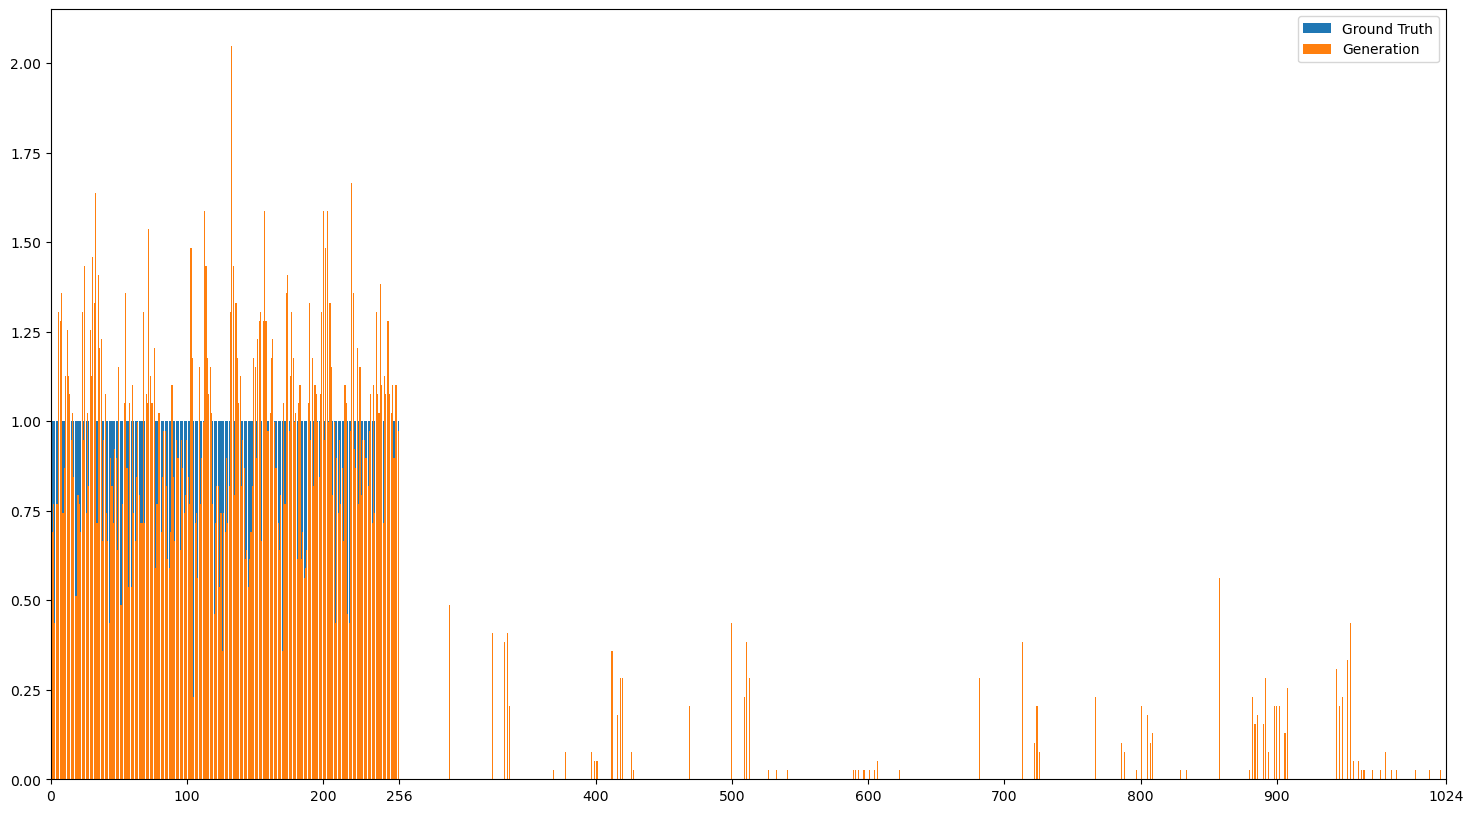

In [952]:
# visualization
x_lim = reordered_set.shape[1]
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - counts_d.size))] = counts_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(np.arange(counts_d.size),counts_d,label = "Ground Truth")
ax.bar(values_t,counts_t,label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

In [953]:
# fig, ax = plt.subplots(figsize=(18, 10))
# ax.bar(values_d,counts_d,label = "Ground Truth")
# ax.bar(values_t,counts_t,label = "Generation")
# ax.set(xlim=(0, values_d.size))
# plt.legend()

In [954]:
statistics

{'percent': 0.9533,
 'FN': array([], dtype=int32),
 'n_fn': 0,
 'FP': array([[ 293,  324,  333,  335,  337,  369,  378,  397,  399,  401,  412,
          416,  418,  420,  426,  428,  469,  500,  509,  511,  513,  527,
          533,  541,  589,  591,  593,  597,  601,  605,  607,  623,  682,
          713,  722,  724,  726,  767,  786,  788,  797,  801,  805,  807,
          809,  829,  834,  858,  880,  882,  884,  886,  890,  892,  894,
          898,  900,  902,  906,  908,  944,  946,  948,  952,  954,  956,
          960,  962,  964,  970,  976,  980,  984,  988, 1002, 1012, 1020],
        [  19,   16,   15,   16,    8,    1,    3,    3,    2,    2,   14,
            7,   11,   11,    3,    1,    8,   17,    9,   15,   11,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    2,    1,   11,
           15,    4,    8,    3,    9,    4,    3,    1,    8,    7,    4,
            5,    1,    1,   22,    1,    9,    6,    7,    6,   11,    3,
            8,    8,    8,    

In [955]:
MSE

0.08059488000000001

#### vanilla

percent: 0.9237,0.929,0.9371,0.9361,0.9324,0.9371,0.9437,0.9403, 0.9495,0.9406,0.9405,0.9431,0.9409

n_fn: 0,0,0,0,0,0,0,0,0,0,0,0,0

n_fp: 102,96,71,64,67,69,66,66,64,63,63,73,65

mse: 0.14,0.20,0.15,0.12,0.09,0.1,0.09,0.09,0.10,0.085,0.0856,0.07565,0.08

#### vanilla -- {1,-1}

percent: 0.6061,0.598,0.6876,0.7785,0.8961,0.8628,0.8902,0.9216,0.927,0.9191,0.9305,0.933,0.9292,0.9321

n_fn: 0,0,0,0,0,0,0,0,0,0,0,0,0,0

n_fp: 473,402,378,352,278,315,289,235,228,240,223,208,205,216

mse: 0.2074,0.2306,0.1741,0.1486,0.1041,0.1087,0.0866,0.0957,0.0945.0.0817,0.0928,0.0744,0.0728,0.0867

Conclusion:

- {1,-1} makes the network converge slower but more stable
- The distribution difference and precision are similar but {1,-1} presents more outliers
- No evidence that {1,-1} is better than {0,1}

#### vanilla -- data bias

percent: 0.9303,0.936,0.9442,0.9562,0.9502,0.9564,0.9489,0.9524,0.9494,0.9495,0.9528,0.9572,0.9558,0.9559,0.9564,0.9553

n_fn: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

n_fp: 97,90,72,57,62,59,56,50,58,56,58,51,56,55,51,50

mse: 0.1061,0.1076,0.0881,0.1080,0.0887,0.0753,0.0871,0.0843,0.0717,0.0691,0.0769,0.0717,0.0688,0.0696,0.0781,0.0727

Conclusion:

- improved performance on all dimensions of measurement

#### vanilla -- instantiation bias

percent: 0.9027,0.9007,0.8943,0.8936,0.9159,0.9127,0.9305,0.9241,0.923,0.9281,0.934,0.9297

n_fn: 0,0,0,0,0,0,0,0,0,0,0,0,0

n_fp: 108,94,104,96,101,90,92,91,91,86,87,78

mse: 0.2791,0.1675,0.1301,0.1242,0.1163,0.1135,0.1355,0.1054,0.1098,0.1,0.0866,0.0848

Conclusion: 

- worse performance than the vanilla model

#### vanilla -- instantiation bias & data bias

percent: 0.9288,0.9332,0.9346,0.9452,0.9485,0.9492,0.9515,0.9487,0.954,0.9554

n_fn: 0,0,0,0,0,0,0,0,0,0

n_fp: 106,79,75,68,63,68,56,60,55,58

mse: 0.1086,0.0934,0.1075,0.1097,0.0981,0.085,0.091,0.0868,0.0764,0.0856

Conclusion:
- Doesn't outperform the data bias only case. Seems there's no reason to add instantiation bias in this case

#### vanilla -- one more layer

percent: 0.9237,0.9433,0.9378,0.9447,0.953,0.9545,0.9546,0.95,0.9529

n_fn: 0,0,0,0,0,0,0,0,0

n_fp: 105,70,70,66,60,66,54,63,59

mse: 0.1321,0.1102,0.0821,0.0689,0.0727,0.0779,0.0738,0.0611,0.0647

Conclusion:

- It outperforms the vanilla version

#### vanilla -- change the added instantiation layer to activation layer

percent: 0.9208,0.949,0.941,0.9402,0.9436,0.9429,0.9409,0.9394,0.9437,0.9452

n_fn: 0,0,0,0,0,0,0,0,0,0

n_fp: 124,104,86,73,71,68,70,74,61,67

mse: 0.1134,0.1189,0.0933,0.0867,0.0798,0.0734,0.0738,0.0802,0.0761,0.0696

Conclusion:
- it improves the vanilla version a little bit but not as much as its instantiation conjugate.

#### vanilla -- add activation layer between each layer ([10,8,6,3,1] --> [10,(9),8,(7),6,(5),3,(2),1])

percent: 0.8129,0.8233,0.8243,0.8137,0.8142

n_fn: 0,0,0,0,0

n_fp: 154,144,138,135,136

mse: 0.1675,0.1721,0.1606,0.1587,0.1670

Conclusion:
- So bad, shouldn't be. Maybe I wrote something wrong, maybe for another trial.

#### vanilla -- add instantiation layer between each layer ([10,8,6,3,1] --> [10,9,8,7,6,5,3,2,1])

percent: 0.9261,0.9356,0.9387,0.9563,0.9481,0.9521,0.95,0.9582,0.9535,0.9559,0.9533,0.9541,0.9533

n_fn: 0,0,0,0,0,0,0,0,0,0,0,0,0

n_fp: 118,122,111,102,107,92,95,97,92,91,81,78,77

mse: 0.1403,0.1291,0.1104,0.1218,0.0888,0.1033,0.0969,0.1027,0.0789,0.0853,0.0863,0.073,0.0805

Conclusion:
- It works but doesn't perform as well as expected; doesn't show much improvement

In [956]:
Theta

{'Theta_10': array([[ 1.80545922e+00,  2.38136505e+00,  2.02559191e+00,
          1.37810896e+00,  2.03346936e+00,  3.14131605e+00,
          4.43259714e+00,  2.43791638e+00,  4.01432821e+00,
          8.98418612e+00],
        [ 8.94748627e-02,  1.01760186e+01, -2.75469195e-02,
          9.11117545e-02,  7.48641602e-02, -3.50636061e-02,
         -3.47624160e-01,  3.35699066e-02, -2.80273177e-02,
         -2.58989891e+01],
        [-7.55097093e-02, -7.89645503e+00,  7.34088545e-02,
          1.18022399e+00,  2.23089040e-01,  6.05104789e-01,
          5.55701045e+00,  2.66752192e-01,  7.63221018e-01,
          7.06287767e+01],
        [-1.17801719e-01,  3.75016049e-01, -1.58069824e-01,
         -1.24091272e+00,  7.07099683e-01, -3.72936088e+00,
          2.82434109e+00, -2.58312720e-01,  6.45619853e-01,
          2.24281347e+01],
        [ 1.55909819e-01,  7.30731919e-02,  1.85687444e-01,
         -1.45080648e+00,  1.52039761e-02,  3.51199381e+00,
         -1.53269505e+00,  7.82539210e+0

In [957]:
Phi

{'Phi_01': array([[-1.08124298e+01, -3.08489307e-02, -1.19700342e-01,
         -1.48145473e-01,  1.63999934e-01, -5.16467338e-01,
          3.27228193e+00, -5.02737767e+00,  6.93071278e+00,
          5.21449000e+00, -1.46637002e+01],
        [-3.29923050e+00,  9.45941619e+00, -7.43009415e+00,
          3.28453225e-01,  7.20373146e-02,  3.88275458e-01,
          1.21475465e-01,  2.29195353e-01,  1.41920346e-01,
         -8.08890554e-02, -6.23782885e+00],
        [-1.70858185e-01, -4.00479959e-02, -9.35877576e-03,
         -1.30278954e-01,  3.32906301e-01, -1.97881099e+00,
          6.42541565e+00, -4.94431587e+00, -6.96017299e-02,
         -5.86726429e+00, -2.06285783e+00],
        [-3.07687589e+00,  6.75561347e-02,  1.03788893e+00,
         -1.20260452e+00, -1.44346730e+00, -8.73471983e-01,
          1.79146223e-01, -3.53006632e-01,  1.96028307e+00,
         -7.73804449e-01, -6.24029099e+00],
        [ 1.51096982e-01,  1.17935672e-01,  1.02226498e-01,
          6.06354432e-01,  1.43344

In [568]:
# fig, ax = plt.subplots(3, 1,figsize=(18, 10))
# ax[0].bar(values_d,counts_d)
# ax[0].set_title("Ground Truth")
# ax[1].bar(values_t,counts_t)
# ax[1].set_title("Generation")
# ax[2].bar(values_d,counts_d,label = "Ground Truth")
# ax[2].bar(values_t,counts_t,label = "Generation")
# for i in range(3):
#     ax[i].set(xlim=(0, x_lim), xticks=xtick)
# plt.legend()

In [834]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [836]:
np.save('parameters_vanilla.npy',parameters)

In [840]:
para = np.load('parameters_vanilla.npy',allow_pickle=True).item()

In [843]:
para['Phi']

{'Phi_01': array([[ 1.92796655e+00,  2.94443837e-01,  1.20437446e-01,
         -2.93494387e+00,  1.14451998e+00,  1.24251114e+00,
          1.51921169e+00,  1.59644270e-03,  1.43610993e-01,
         -3.27353442e-01, -8.07596068e-01],
        [ 9.61126670e-01, -7.64624720e-02,  2.61773104e-02,
          1.98567201e-01,  2.36421360e-01,  4.22571126e-01,
         -3.11872392e-01,  1.77729163e+00,  2.11794095e+00,
         -2.82399176e+00, -1.59537280e+00],
        [ 1.43496948e+00,  1.99793054e-01, -3.59512838e-01,
          3.76847494e-01, -4.47598269e+00, -5.36343000e+00,
          1.76820195e+00,  1.41831424e+00,  8.15743805e-01,
          1.51699929e-01, -1.89982373e+00],
        [ 3.97379809e+00,  1.39237874e+00,  3.76179067e-01,
          1.33692692e+00,  5.76617340e-01,  2.07658835e+00,
          7.45678413e-01,  1.77486527e+00,  6.16503991e-01,
          1.46255757e+00,  1.52595770e+00],
        [-7.86013507e-01,  4.27564694e-02, -1.21812688e-01,
          3.76855770e-02,  5.70128